In [11]:
import pickle
with open('train.pkl','rb') as f:
    data = pickle.load(f)
# data

In [12]:
import numpy as np
from PIL import Image
image_data = []
image_data_transposed = []
for image in data['images']:
    image_data.append(np.array(image))
    image_data_transposed.append(np.array(image).transpose((2, 0, 1))/255.0)
# image_data 

In [13]:
labels = data['labels']
# labels

In [14]:
import PIL
def display_images(images):
        img = Image.fromarray(images)
        display(img.resize((128,128),PIL.Image.LANCZOS))

##  Question1: Display 10 random images from each class

In [15]:
unique_labels = list(set(labels))
label_image_dict = {key:[] for key in unique_labels}

In [16]:
label_image_dict

{0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

In [17]:



# for key in unique_labels:
    

In [18]:
labels_arr = np.array(labels)


In [19]:
labels[4936]

0

labels:0


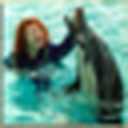

labels:0


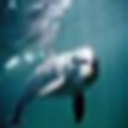

labels:0


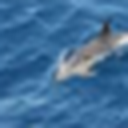

labels:0


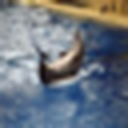

labels:0


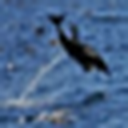

labels:0


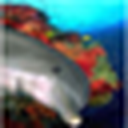

labels:0


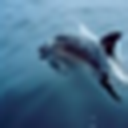

labels:0


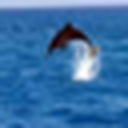

labels:0


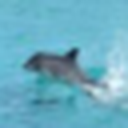

labels:0


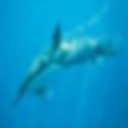

labels:1


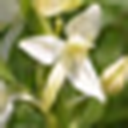

labels:1


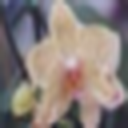

labels:1


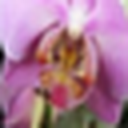

labels:1


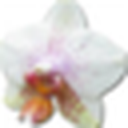

labels:1


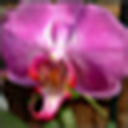

labels:1


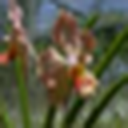

labels:1


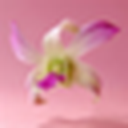

labels:1


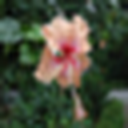

labels:1


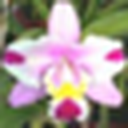

labels:1


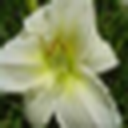

labels:2


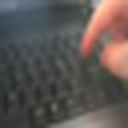

labels:2


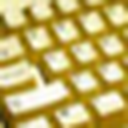

labels:2


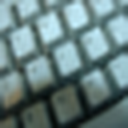

labels:2


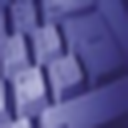

labels:2


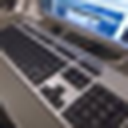

labels:2


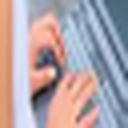

labels:2


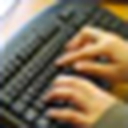

labels:2


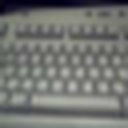

labels:2


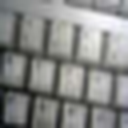

labels:2


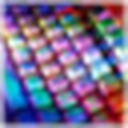

labels:3


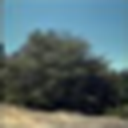

labels:3


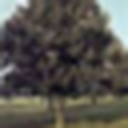

labels:3


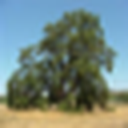

labels:3


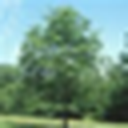

labels:3


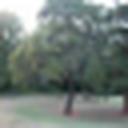

labels:3


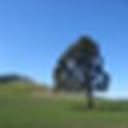

labels:3


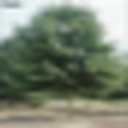

labels:3


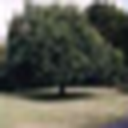

labels:3


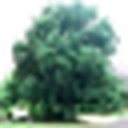

labels:3


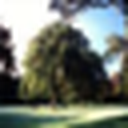

labels:4


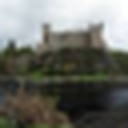

labels:4


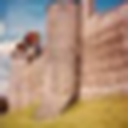

labels:4


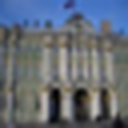

labels:4


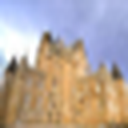

labels:4


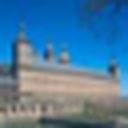

labels:4


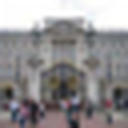

labels:4


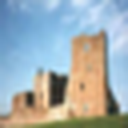

labels:4


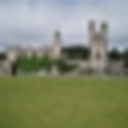

labels:4


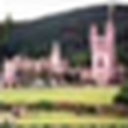

labels:4


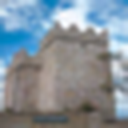

labels:5


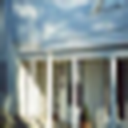

labels:5


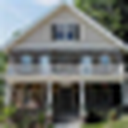

labels:5


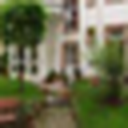

labels:5


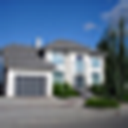

labels:5


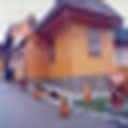

labels:5


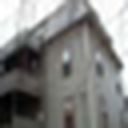

labels:5


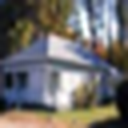

labels:5


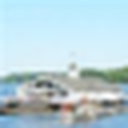

labels:5


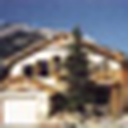

labels:5


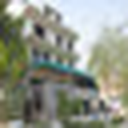

labels:6


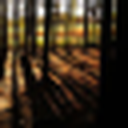

labels:6


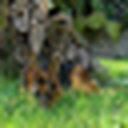

labels:6


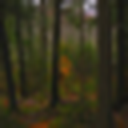

labels:6


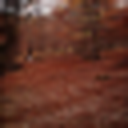

labels:6


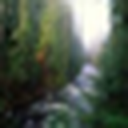

labels:6


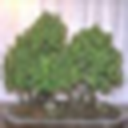

labels:6


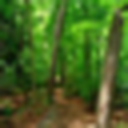

labels:6


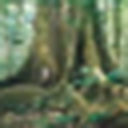

labels:6


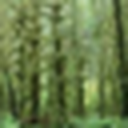

labels:6


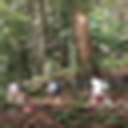

labels:7


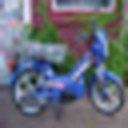

labels:7


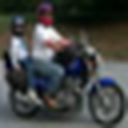

labels:7


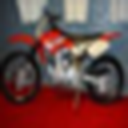

labels:7


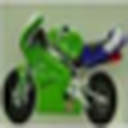

labels:7


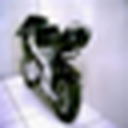

labels:7


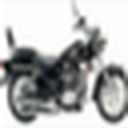

labels:7


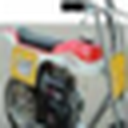

labels:7


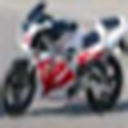

labels:7


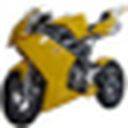

labels:7


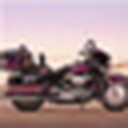

labels:8


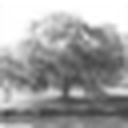

labels:8


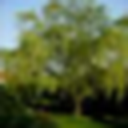

labels:8


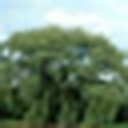

labels:8


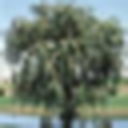

labels:8


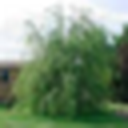

labels:8


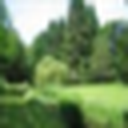

labels:8


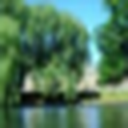

labels:8


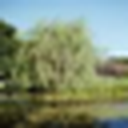

labels:8


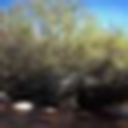

labels:8


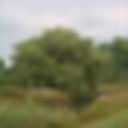

labels:9


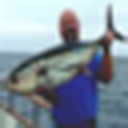

labels:9


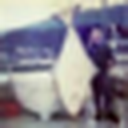

labels:9


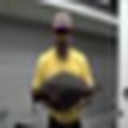

labels:9


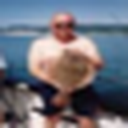

labels:9


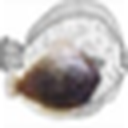

labels:9


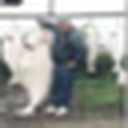

labels:9


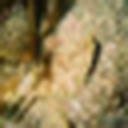

labels:9


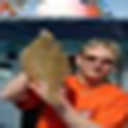

labels:9


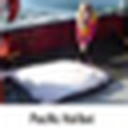

labels:9


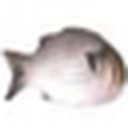

In [20]:
import random
for label in unique_labels:
    indices = np.where(labels_arr==label)[0]
    rand_indices = random.randint(0,30)
    indices = indices[rand_indices:rand_indices+10]
    # print(len(indices))
    for index in indices:
        print("labels:{}".format(label))
        display_images(image_data[index])

In [60]:
import torch.nn as nn

class VGG(nn.Module):
    def vgg_conv_layers(self,number_convolutions, input_channels, output_channels):
        conv_layers = []
        for convolutions in range(number_convolutions):
            conv_layers.append(nn.Conv2d(input_channels,output_channels,kernel_size=3,padding=1))
            conv_layers.append(nn.BatchNorm2d(output_channels))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.Dropout(0))
            input_channels = output_channels
        conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return conv_layers
        
    def __init__(self, image, architecture):
        super(VGG, self).__init__()
        self.image = image
        self.blocks = []

        input_channels =self.image[0].shape[-1]
        for (number_convolutions, output_channels) in architecture:
            self.blocks.append(nn.Sequential(*self.vgg_conv_layers(number_convolutions, input_channels, output_channels)))
            input_channels = output_channels
#         flattened_size = output_channels*int(self.image[0].shape[0])*int(self.image[0].shape[0])

        flattened_size = output_channels*int(self.image[0].shape[0]/(2**len(architecture)))*int(self.image[0].shape[0]/(2**len(architecture)))
        self.network = nn.Sequential(
            *self.blocks,
            nn.Flatten(),
            nn.Linear(flattened_size, flattened_size),
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(flattened_size, flattened_size), 
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(flattened_size, 10)
        )
        



    def forward(self, x, print_falg=False):
        if print_falg:
            for layer in self.network:
                x = layer(x)
                print("layer",layer.__class__.__name__,x.size())
            return x
        else:
            return self.network(x)
    

In [21]:
import joblib
train_dataloader = joblib.load('train_dataloader')
test_dataloader = joblib.load('test_dataloader')
val_dataloader = joblib.load('val_dataloader')

In [22]:
labels_2 = []
for batch in val_dataloader:
    labels_2.append(batch[1].numpy())
list(set(list(np.concatenate(labels_2))))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [23]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [24]:
# code adapted from a  pytorch repo
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [25]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:
epochs=50

## Architecture 3 


In [61]:
vgg_net = VGG(image_data, [(2,16),(2,32), (2,64)])

In [62]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

In [63]:
vgg_net.apply(init_weights)

VGG(
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [64]:
vgg_net.cuda()

VGG(
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [65]:
import torch
X = torch.randn(size=(1, 3, 32, 32)).cuda()

vgg_net(X, print_falg=True)

layer Sequential torch.Size([1, 16, 16, 16])
layer Sequential torch.Size([1, 32, 8, 8])
layer Sequential torch.Size([1, 64, 4, 4])
layer Flatten torch.Size([1, 1024])
layer Linear torch.Size([1, 1024])
layer ReLU torch.Size([1, 1024])
layer Dropout torch.Size([1, 1024])
layer Linear torch.Size([1, 1024])
layer ReLU torch.Size([1, 1024])
layer Dropout torch.Size([1, 1024])
layer Linear torch.Size([1, 10])


tensor([[ 2.1260,  2.0245,  1.1129, -2.0719, -0.9396, -0.9009, -2.1685,  2.3703,
         -4.2377,  1.9264]], device='cuda:0', grad_fn=<AddmmBackward>)

In [66]:
# conv layer dropouts 0 FC layer dropouts 0.4
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0'))

<All keys matched successfully>

In [67]:
def test(test_dataloader, model):
    model.eval()

    predictions , true_labels, ids = [], [], []
    for index,batch in enumerate(test_dataloader):
            image = batch[0]
            x = image.cuda()
            y = batch[1].type(torch.long).cuda()
            with torch.no_grad():
              # Forward pass, calculate logit predictions
                outputs = model.forward(x) 

            logits = outputs
            logits = logits.detach().cpu().numpy()
            label_ids = y.to('cpu').numpy()
            predictions.append(logits)
            true_labels.append(label_ids)
    return predictions, true_labels

In [68]:
predictions, true_labels = test(test_dataloader, vgg_net)

In [69]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

In [70]:
# conv layer dropouts 0 FC layer dropouts 0.4
flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.7053333333333334

## Visualizing convolutional filters

In [71]:
model_weights = []
convolution_layers = []
vgg_net_children = list(vgg_net.children())
for i in range(len(vgg_net_children)):
    if type(vgg_net_children[i]) == nn.Sequential:
        for j in range(len(vgg_net_children[i])):
            for child in vgg_net_children[i][j].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight.detach().cpu().numpy())
                    convolution_layers.append(child)

In [72]:
import matplotlib.pyplot as plt
def visualize_filters(weights):
    plt.figure(figsize=(20, 20))
    for i, filter in enumerate(weights):
        plt.subplot(8, 8, i+1)
        plt.imshow(filter[0, :, :], cmap='gray')
        plt.axis('off')
#         plt.savefig('../outputs/filter.png')
    plt.show()

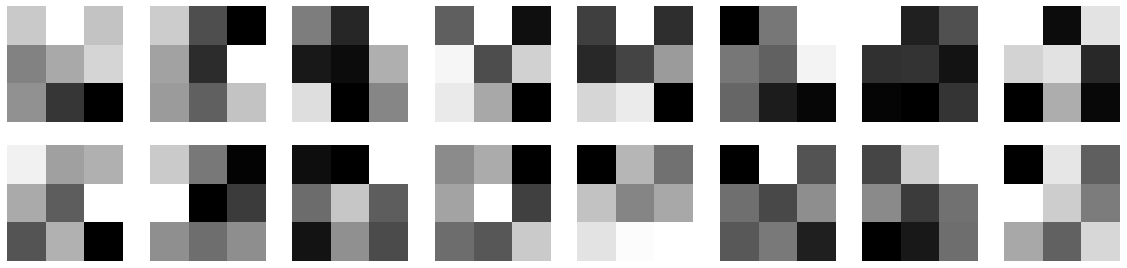

In [98]:
#after first block
visualize_filters(model_weights[1])

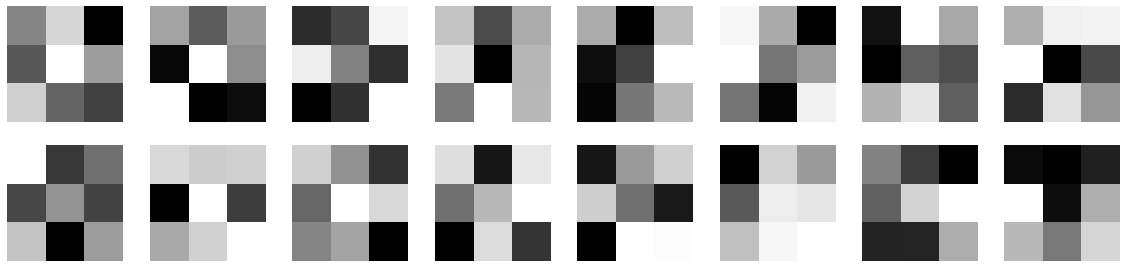

In [99]:
visualize_filters(model_weights[0])

In [60]:
len(model_weights)

6

In [73]:
model_weights[2].shape

(32, 16, 3, 3)

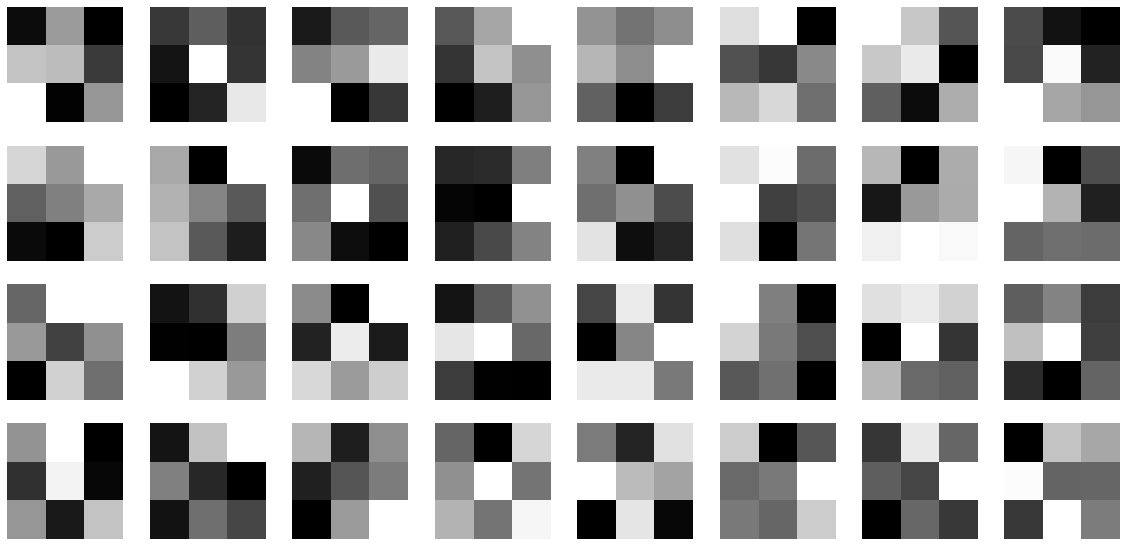

In [85]:
#after second block
visualize_filters(model_weights[3])

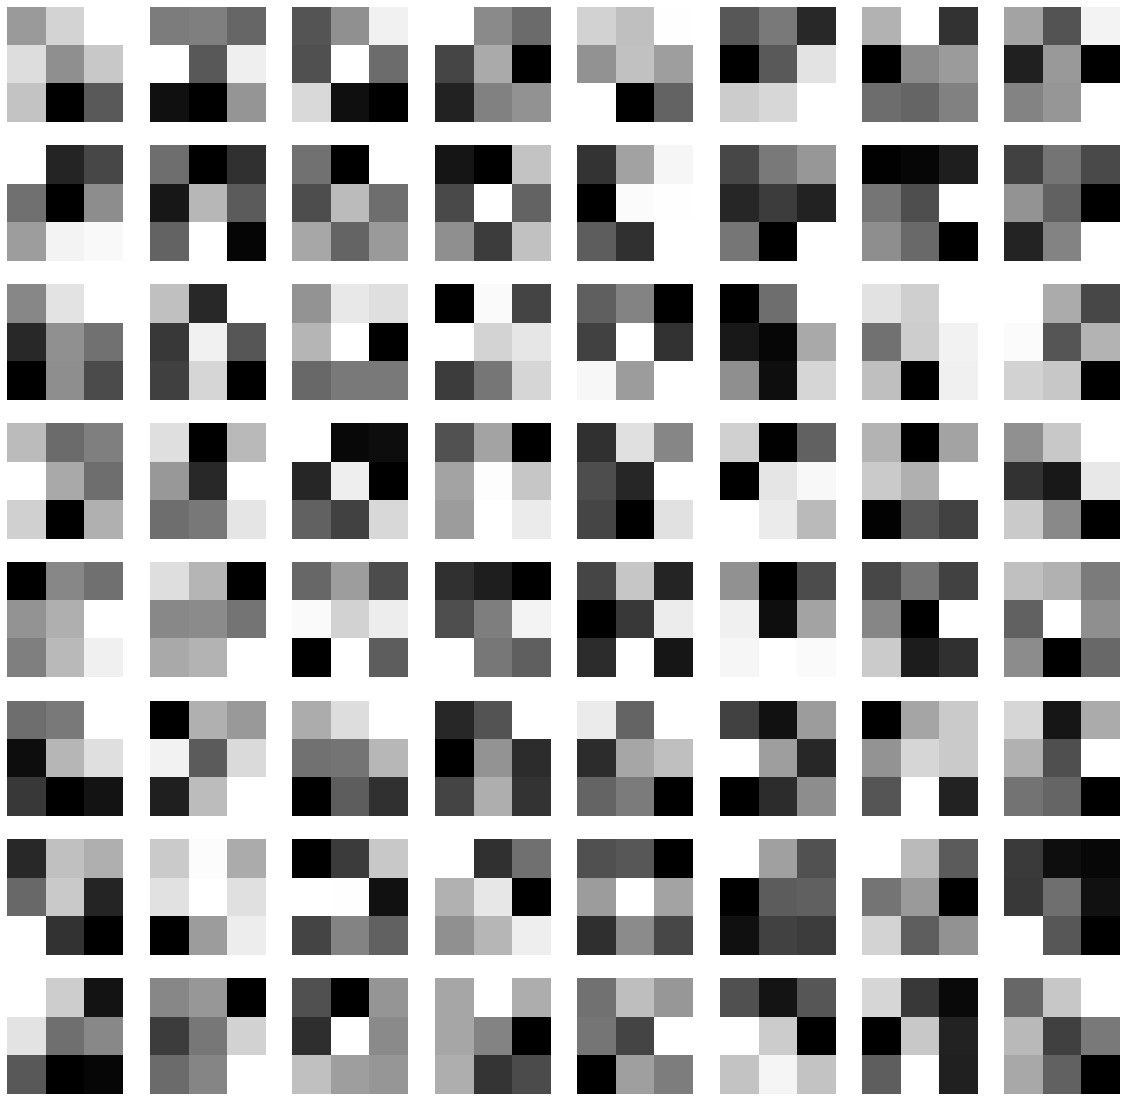

In [88]:
#after third block
visualize_filters(model_weights[5])

## Visualizing feature maps


In [73]:
sample_image = list(test_dataloader)[0][0][12]
conv_outputs = [convolution_layers[0](sample_image.unsqueeze(0).cuda())]
for i in range(1, len(convolution_layers)):
    conv_outputs.append(convolution_layers[i](conv_outputs[-1]))

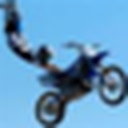

In [74]:
display_images((sample_image.detach().cpu().numpy().transpose((1,2,0))*255).astype('uint8'))

In [75]:
def plot_feature_maps(conv_outputs):
    for num_layer in range(len(conv_outputs)):
        plt.figure(figsize=(30, 30))
        layer_conv = conv_outputs[num_layer][0, :, :, :]
        layer_conv = layer_conv.data
        print(layer_conv.size())
        for i, filters in enumerate(layer_conv):

            plt.subplot(8, 8, i + 1)
            plt.imshow(filters.detach().cpu().numpy(), cmap='gray')
            plt.axis("off")
    #     print(f"Saving layer {num_layer} feature maps...")
    #     plt.savefig(f"../outputs/layer_{num_layer}.png")
        plt.show()
        plt.close()

torch.Size([16, 32, 32])


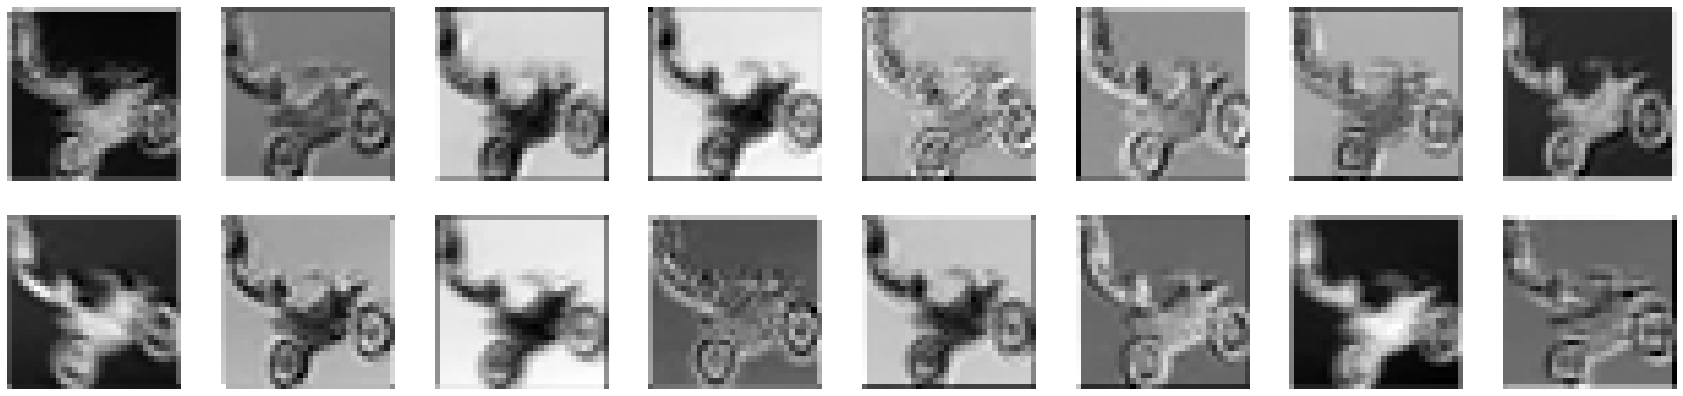

torch.Size([16, 32, 32])


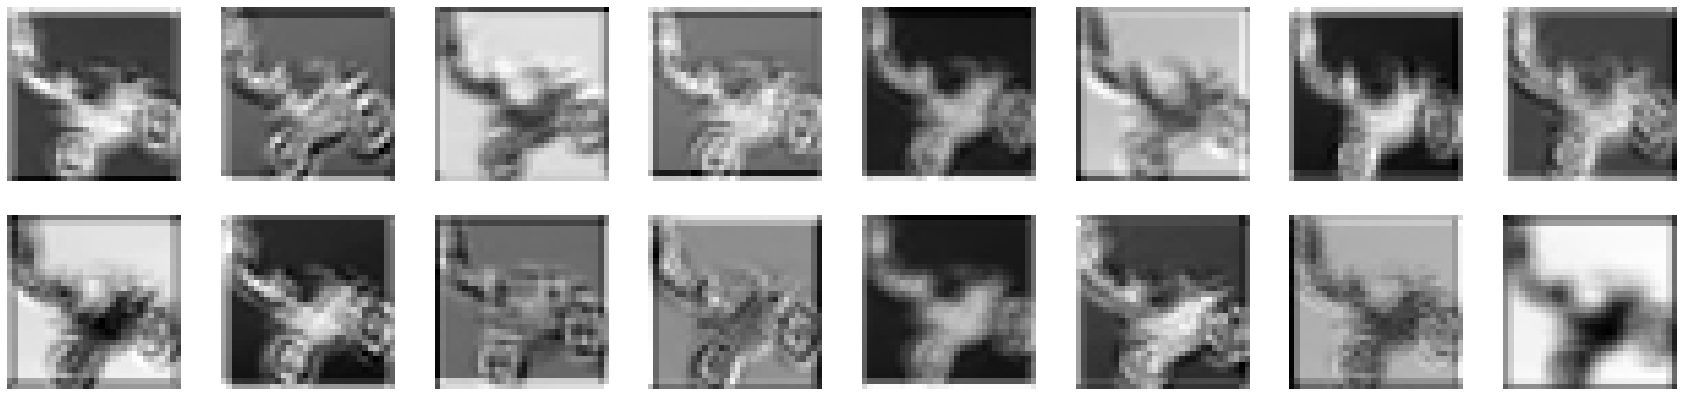

torch.Size([32, 32, 32])


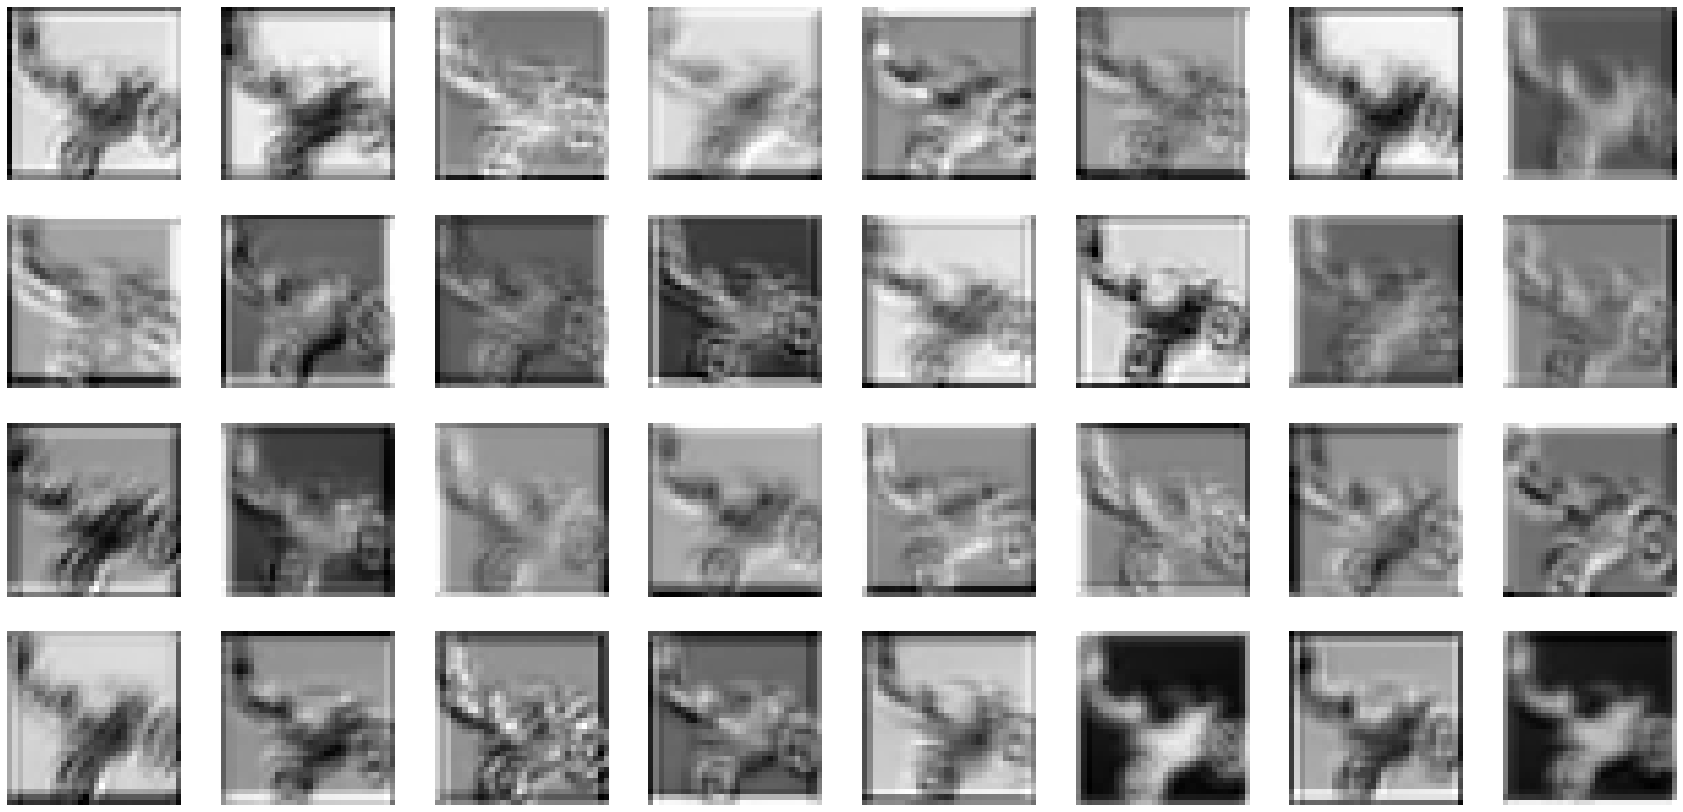

torch.Size([32, 32, 32])


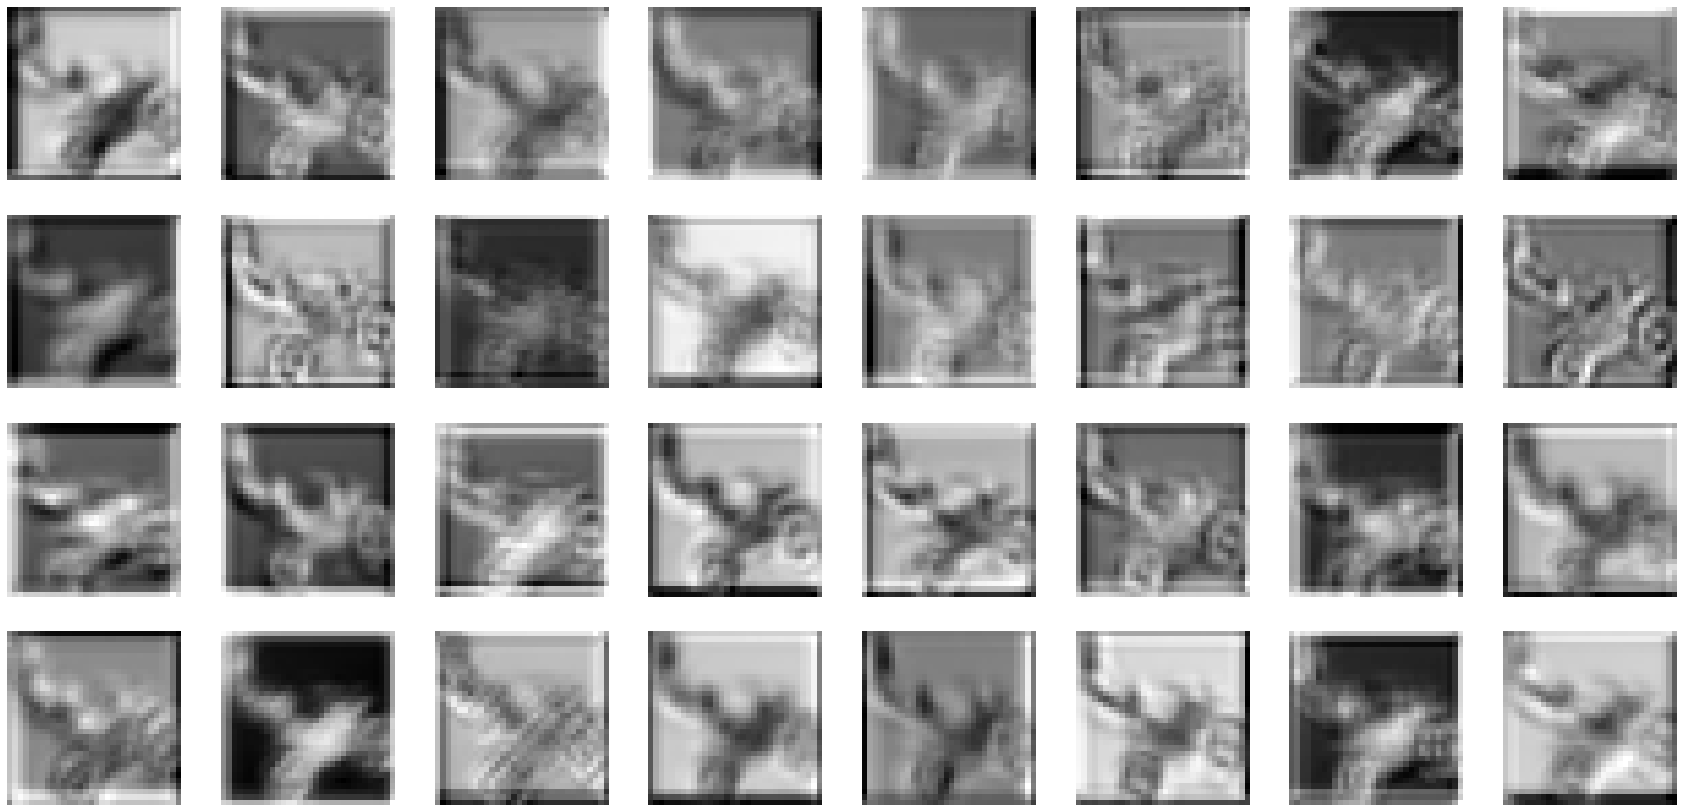

torch.Size([64, 32, 32])


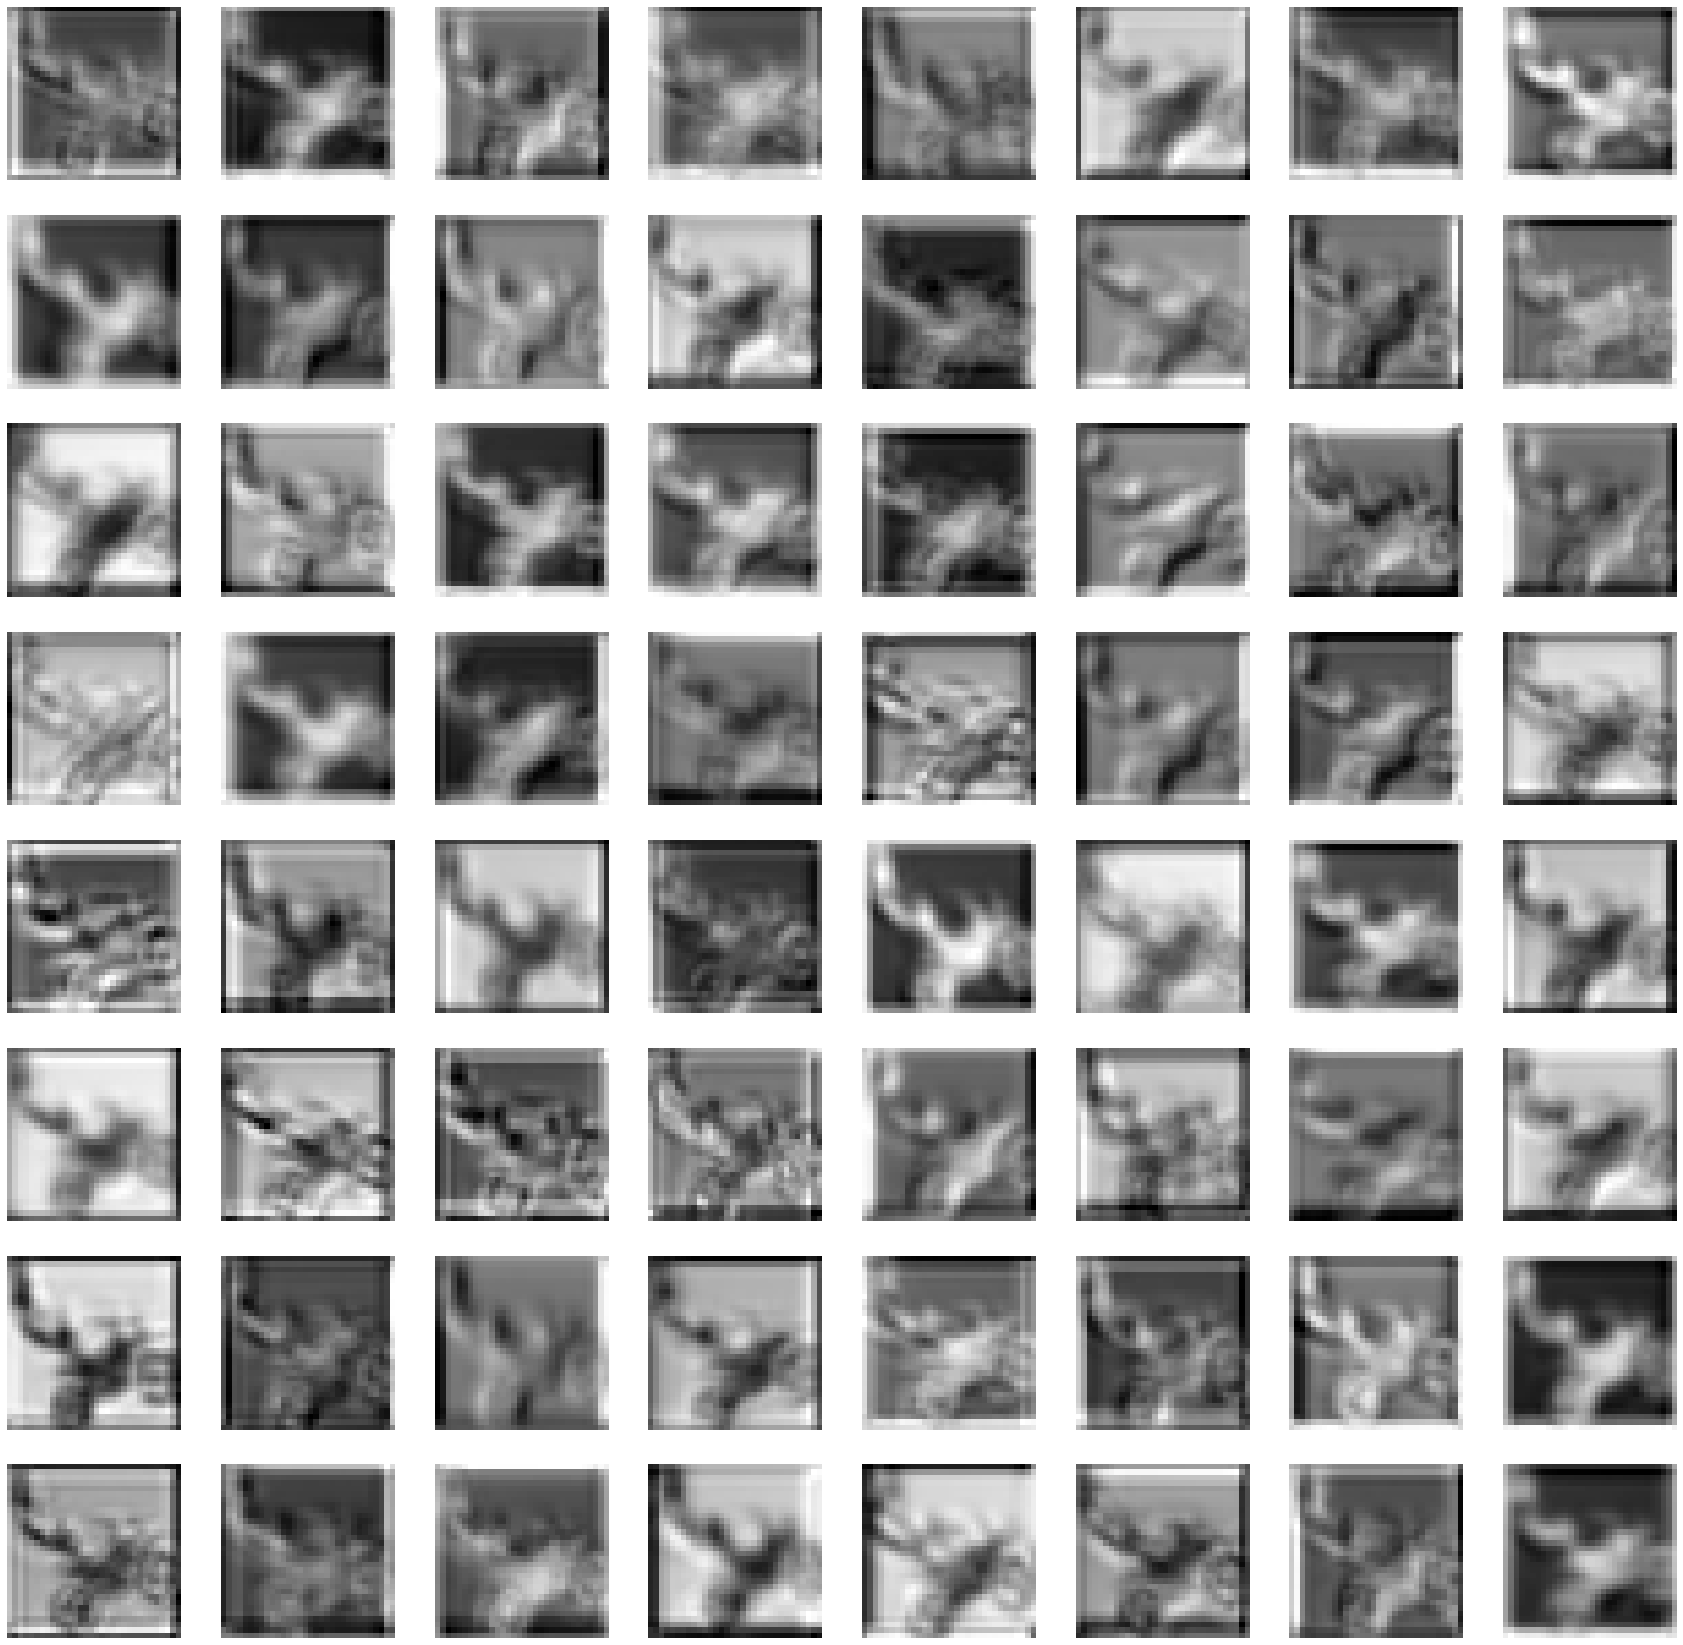

torch.Size([64, 32, 32])


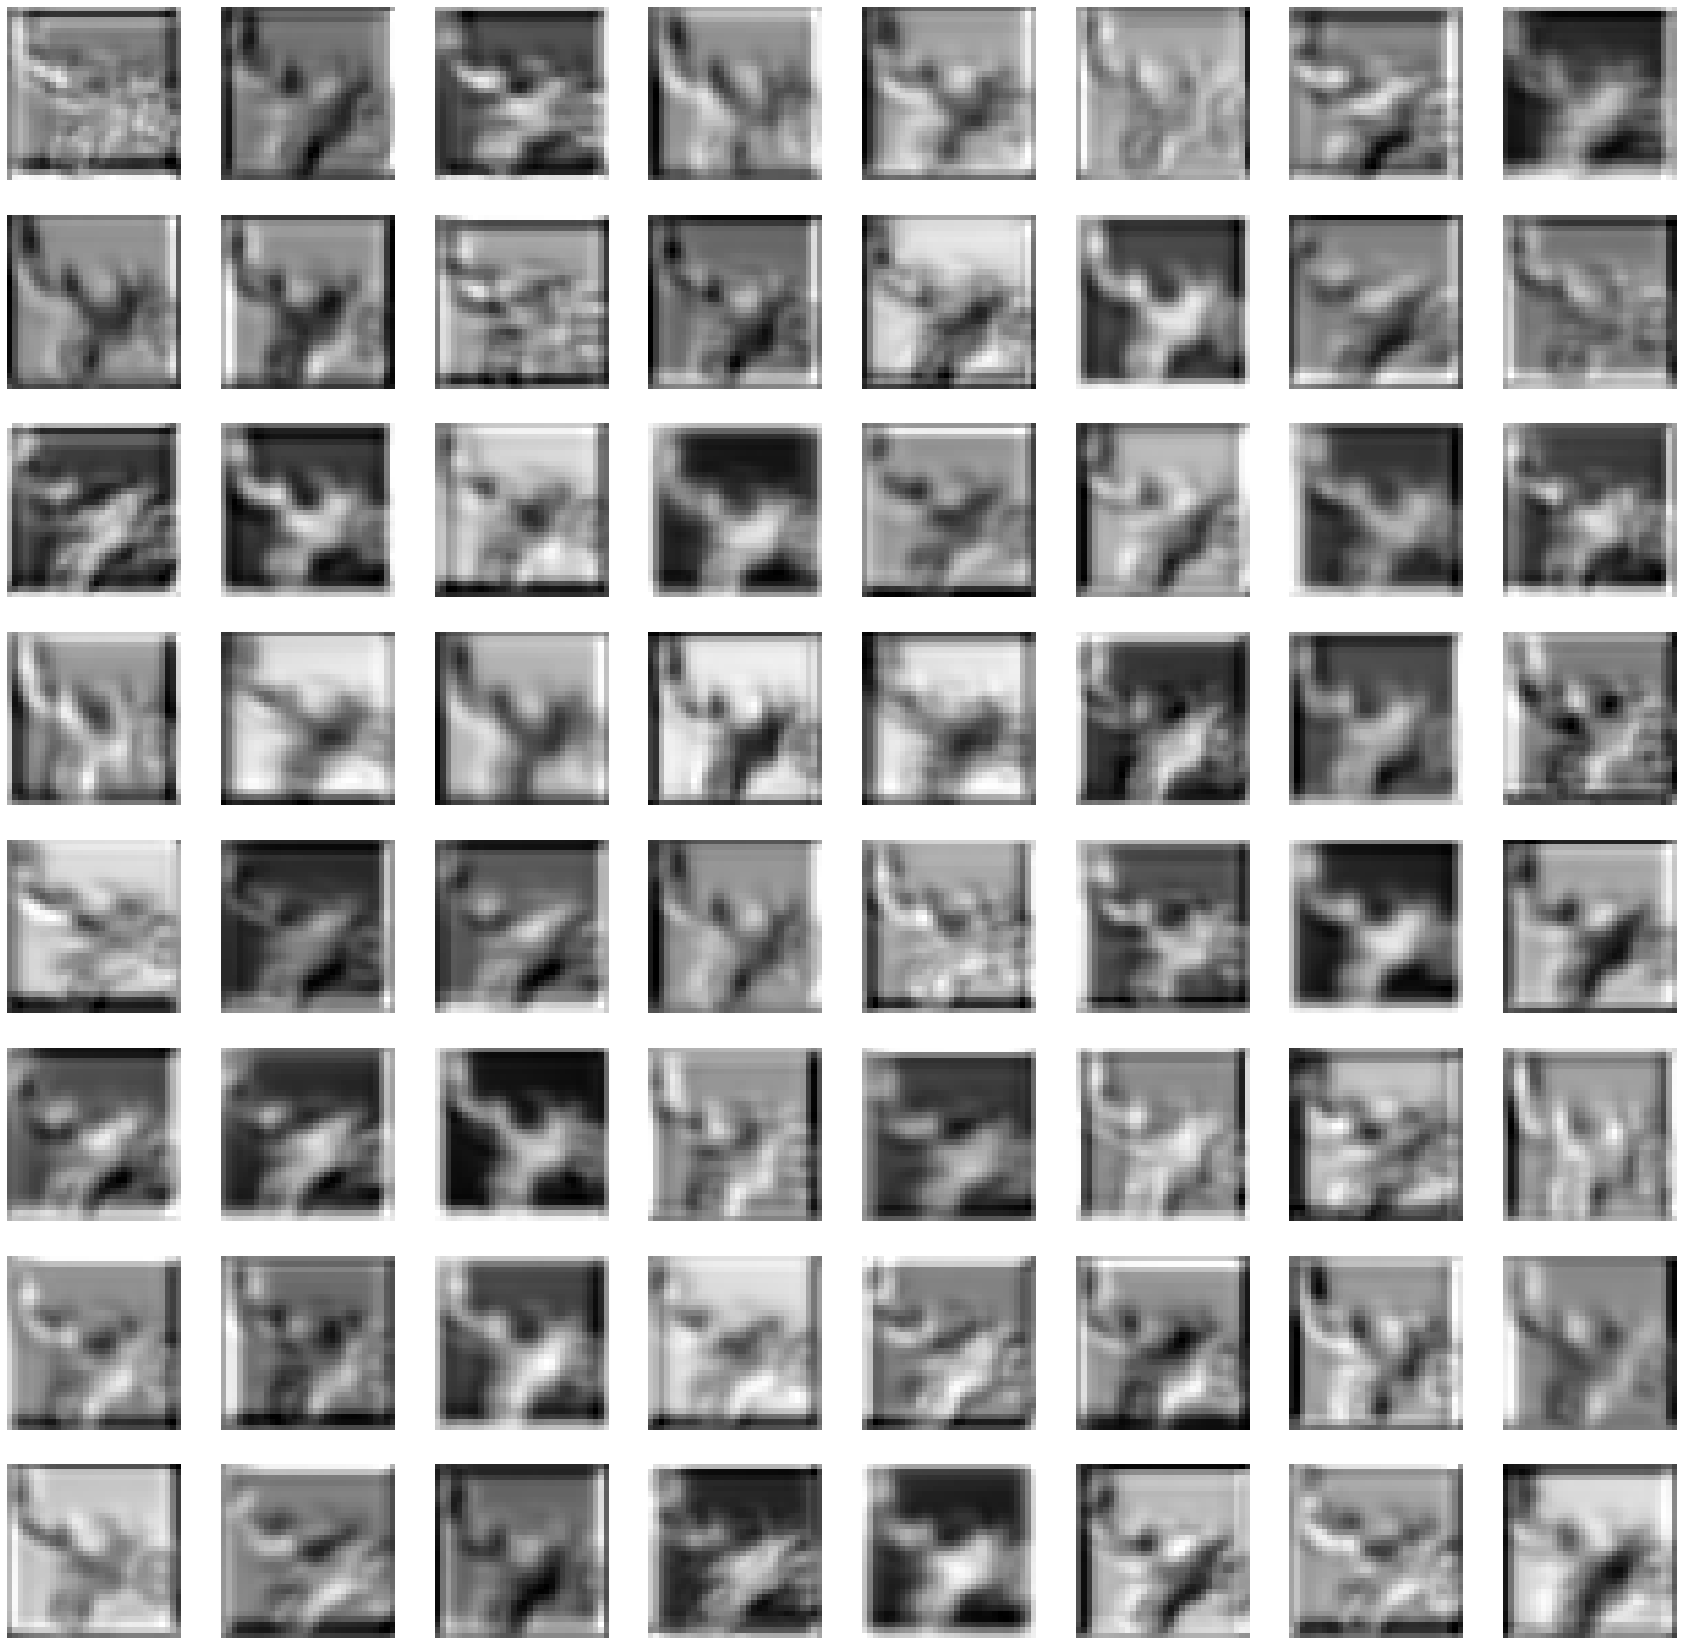

In [76]:
plot_feature_maps(conv_outputs)

## feature maps including pooling layers


In [77]:
model_weights = []
convolution_layers = []
vgg_net_children = list(vgg_net.children())
for i in range(len(vgg_net_children)):
    if type(vgg_net_children[i]) == nn.Sequential:
        for j in range(len(vgg_net_children[i])):
            for child in vgg_net_children[i][j].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight.detach().cpu().numpy())
                if type(child) == nn.Conv2d or type(child) == nn.MaxPool2d:
                    convolution_layers.append(child)

In [78]:
len(convolution_layers)

9

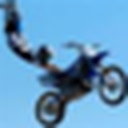

In [79]:
display_images((sample_image.detach().cpu().numpy().transpose((1,2,0))*255).astype('uint8'))

In [80]:
sample_image = list(test_dataloader)[0][0][12]
conv_outputs = [convolution_layers[0](sample_image.unsqueeze(0).cuda())]
for i in range(1, len(convolution_layers)):
    conv_outputs.append(convolution_layers[i](conv_outputs[-1]))

torch.Size([16, 32, 32])


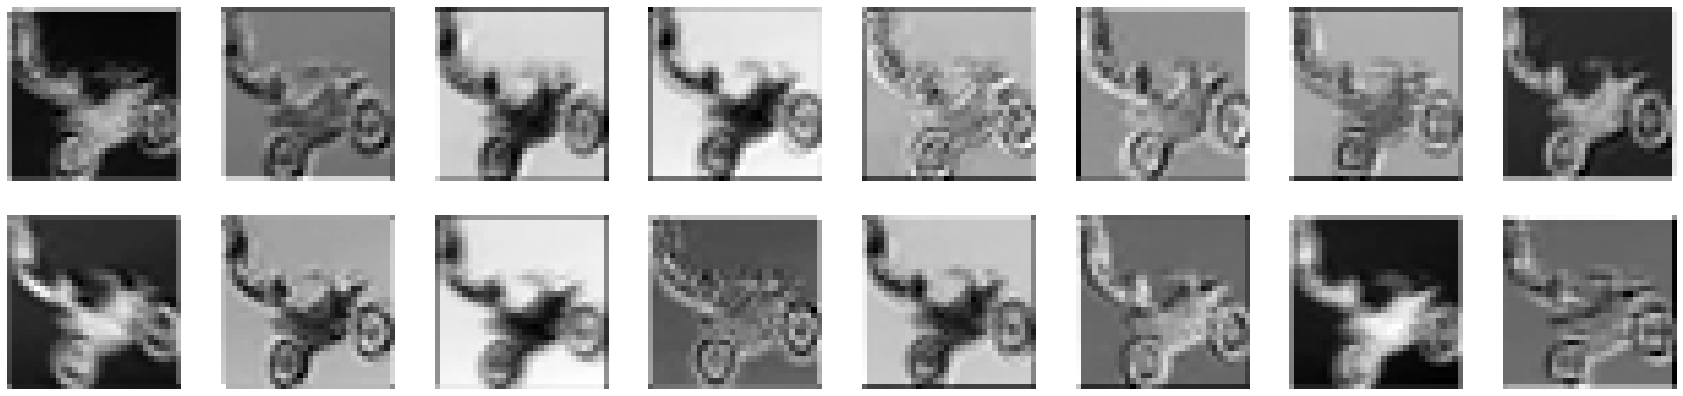

torch.Size([16, 32, 32])


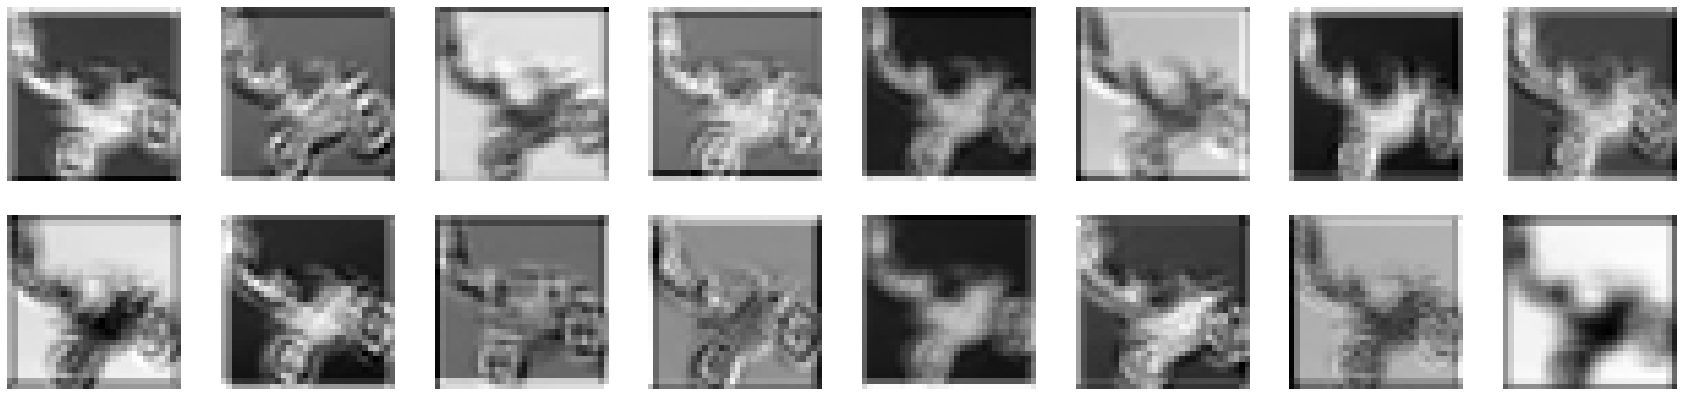

torch.Size([16, 16, 16])


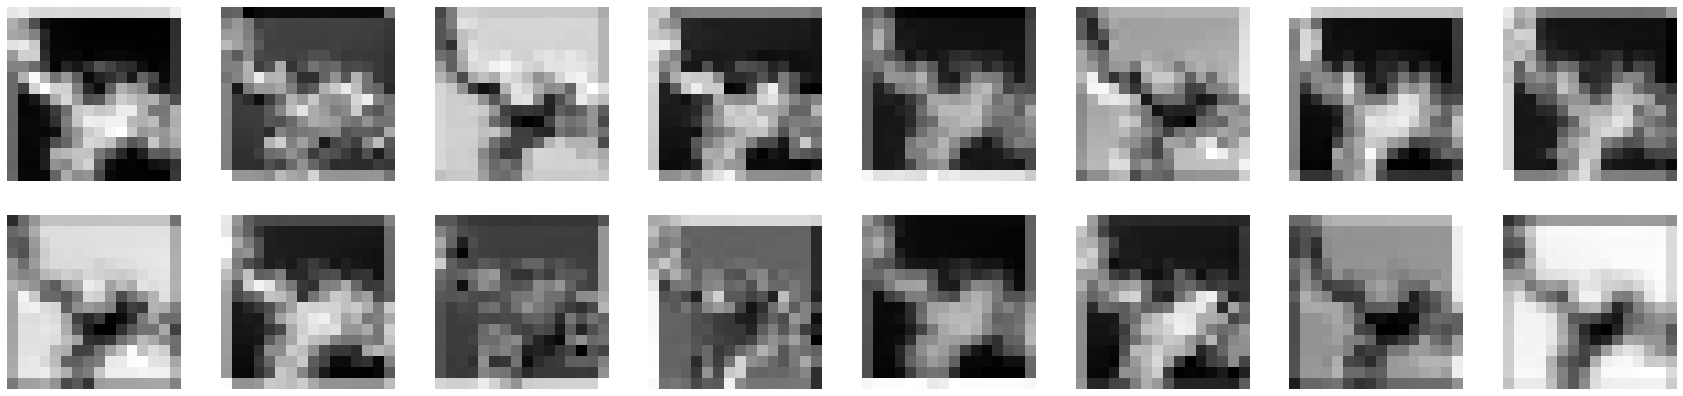

torch.Size([32, 16, 16])


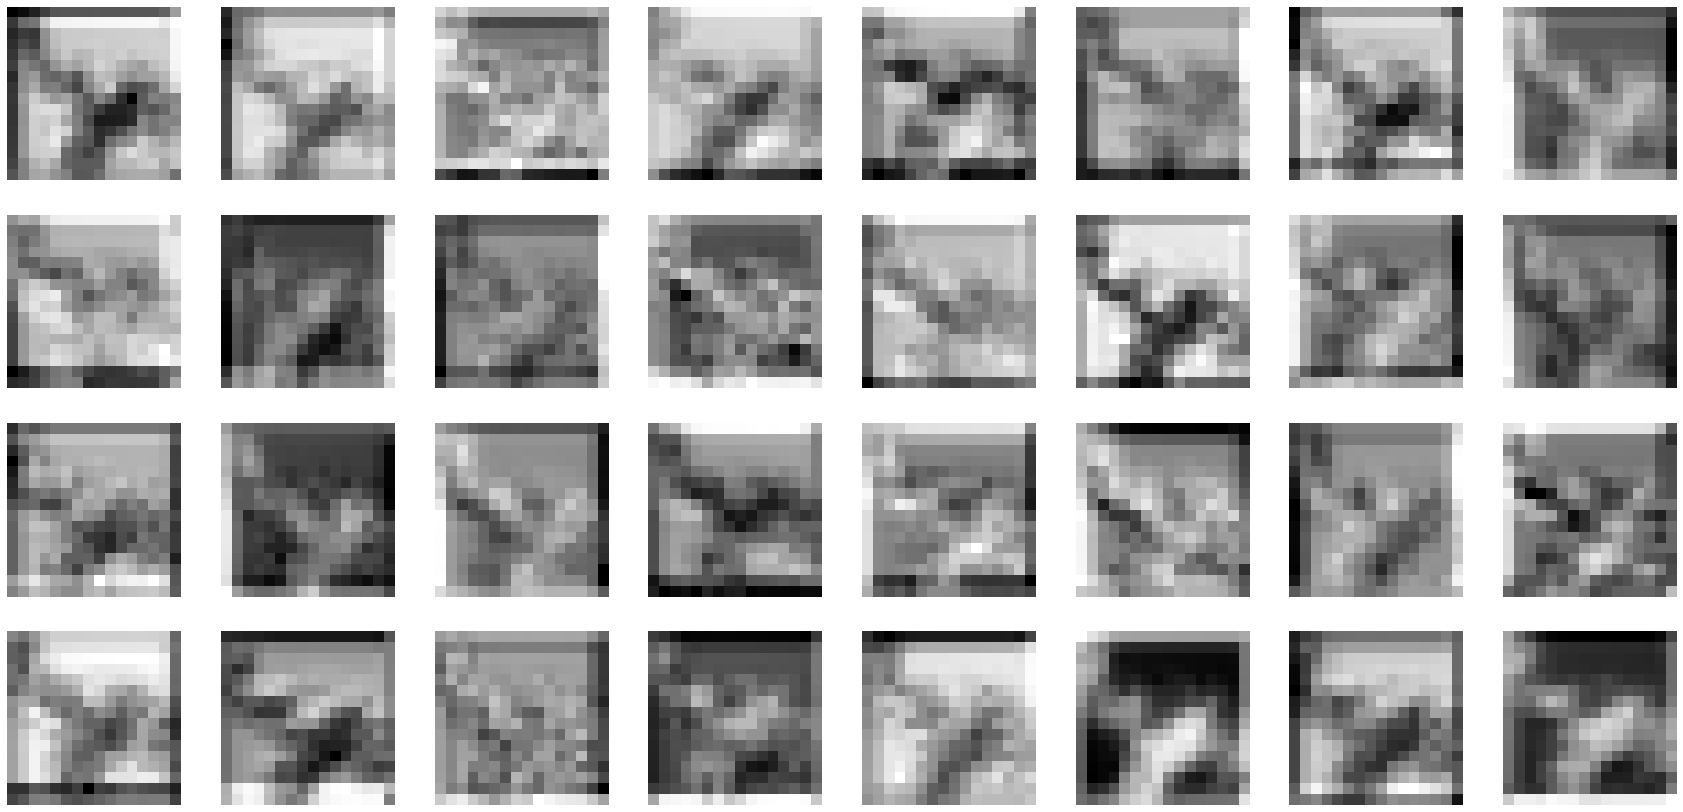

torch.Size([32, 16, 16])


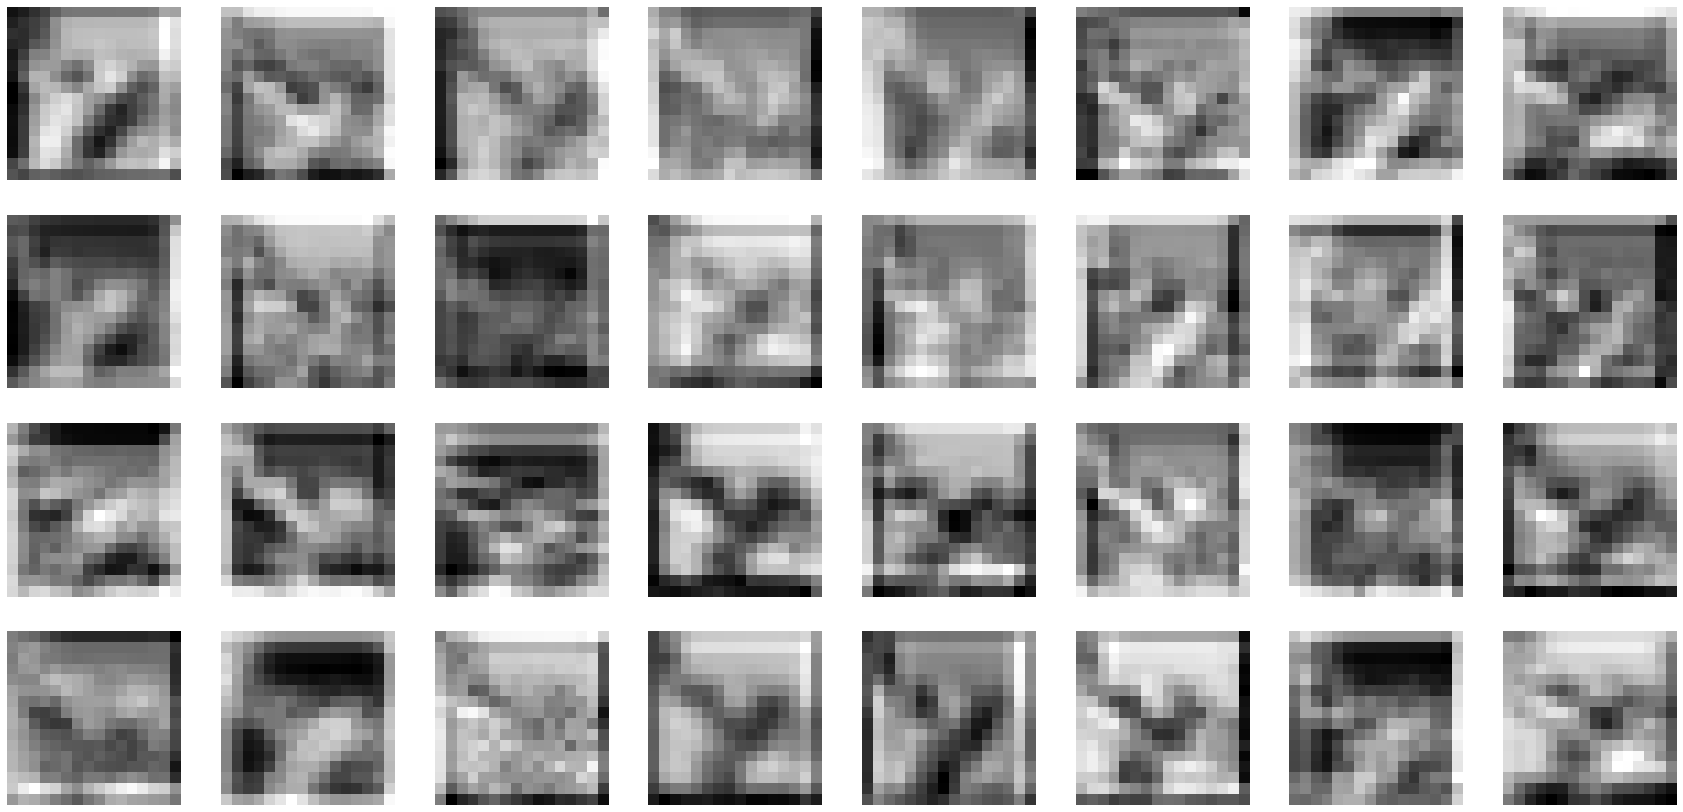

torch.Size([32, 8, 8])


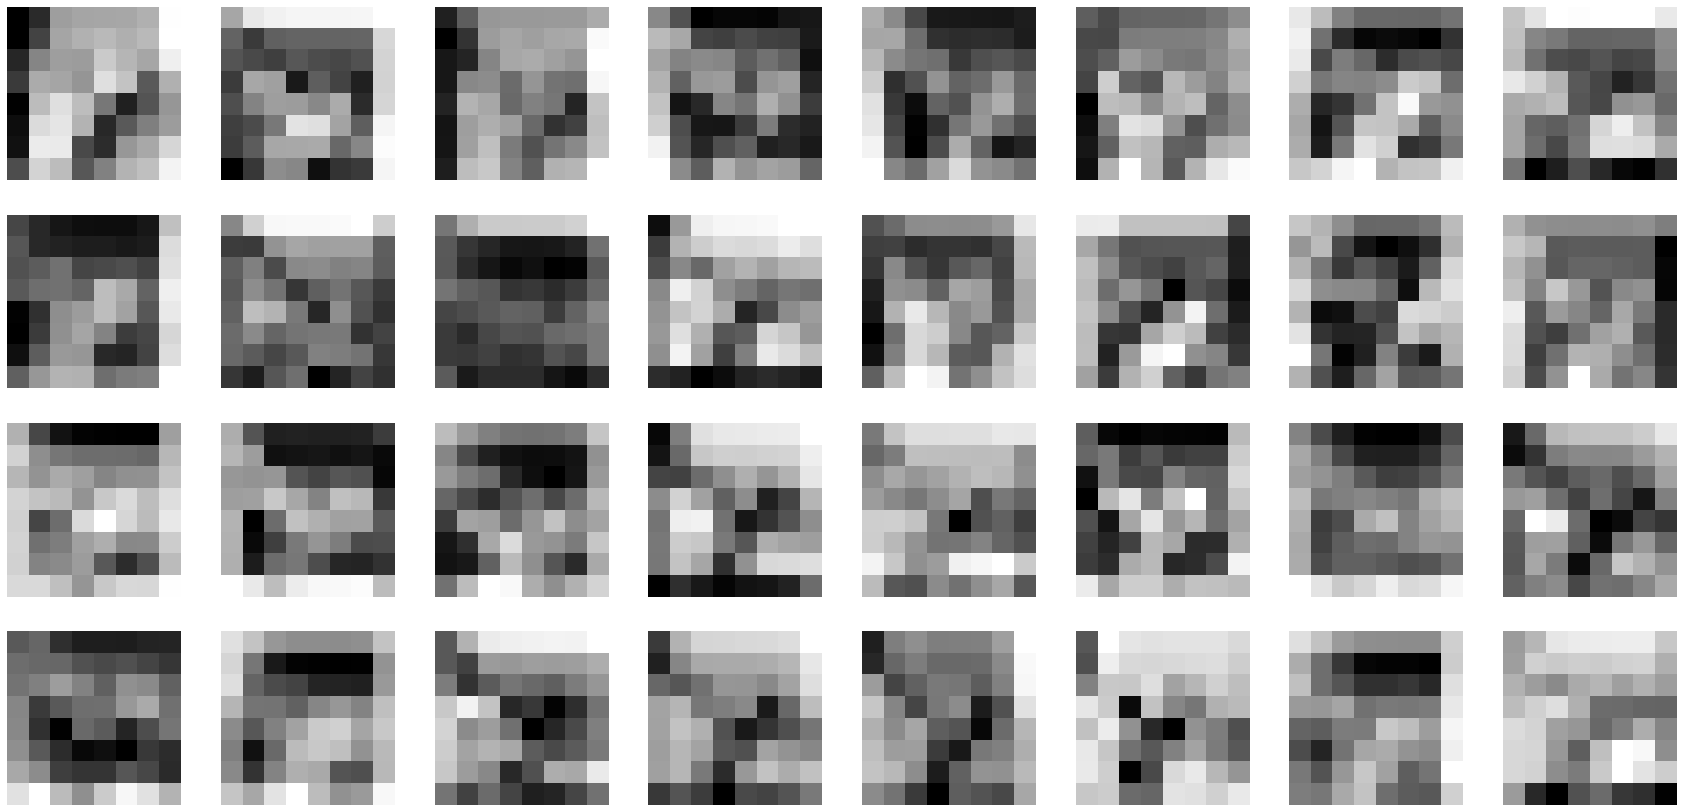

torch.Size([64, 8, 8])


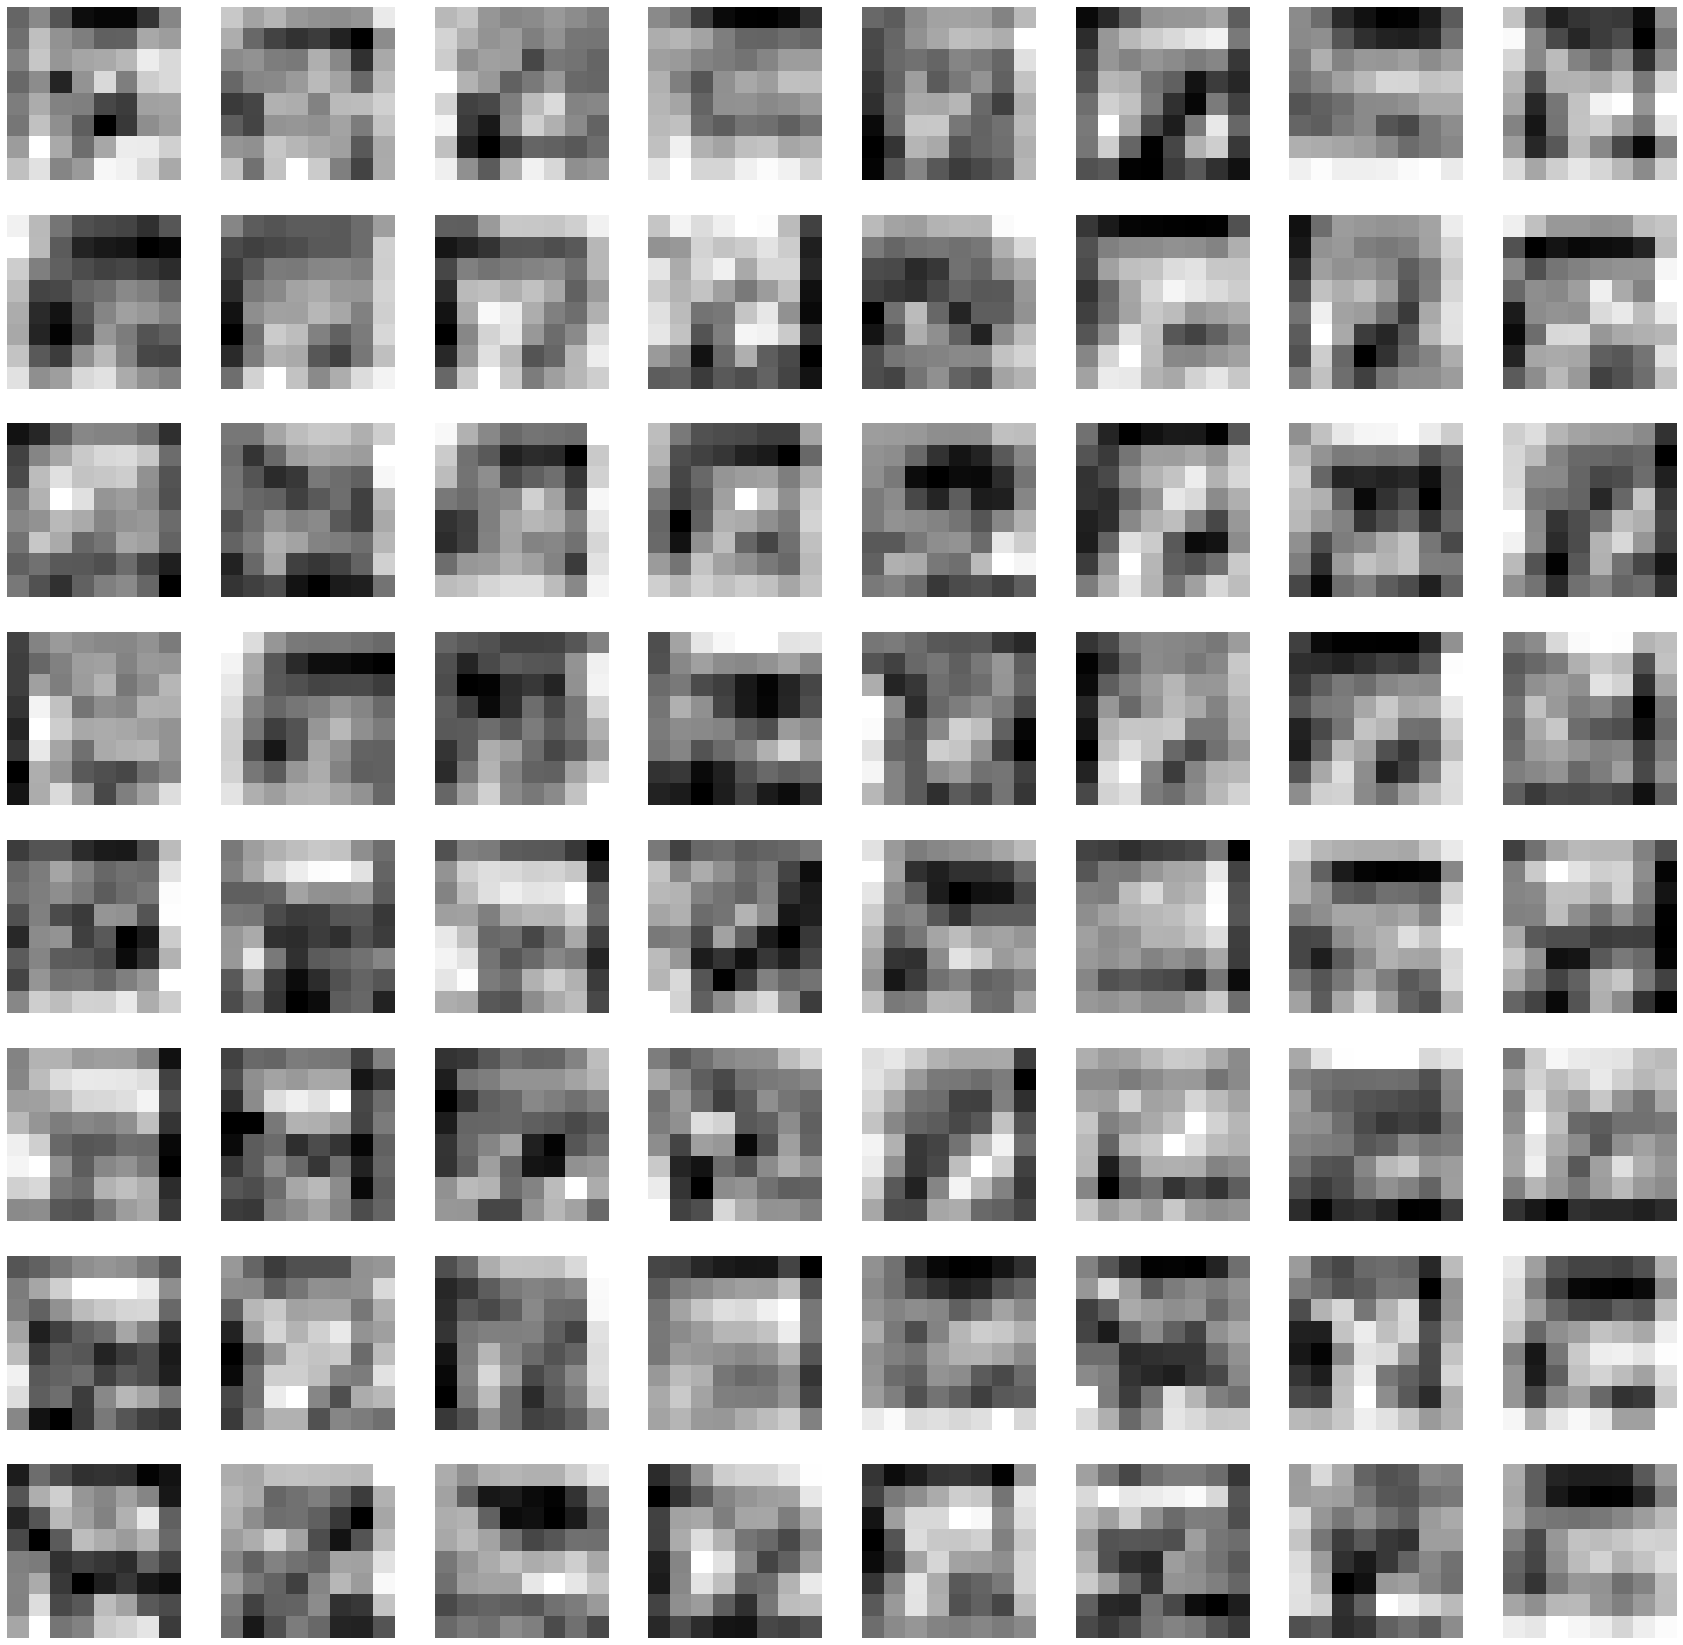

torch.Size([64, 8, 8])


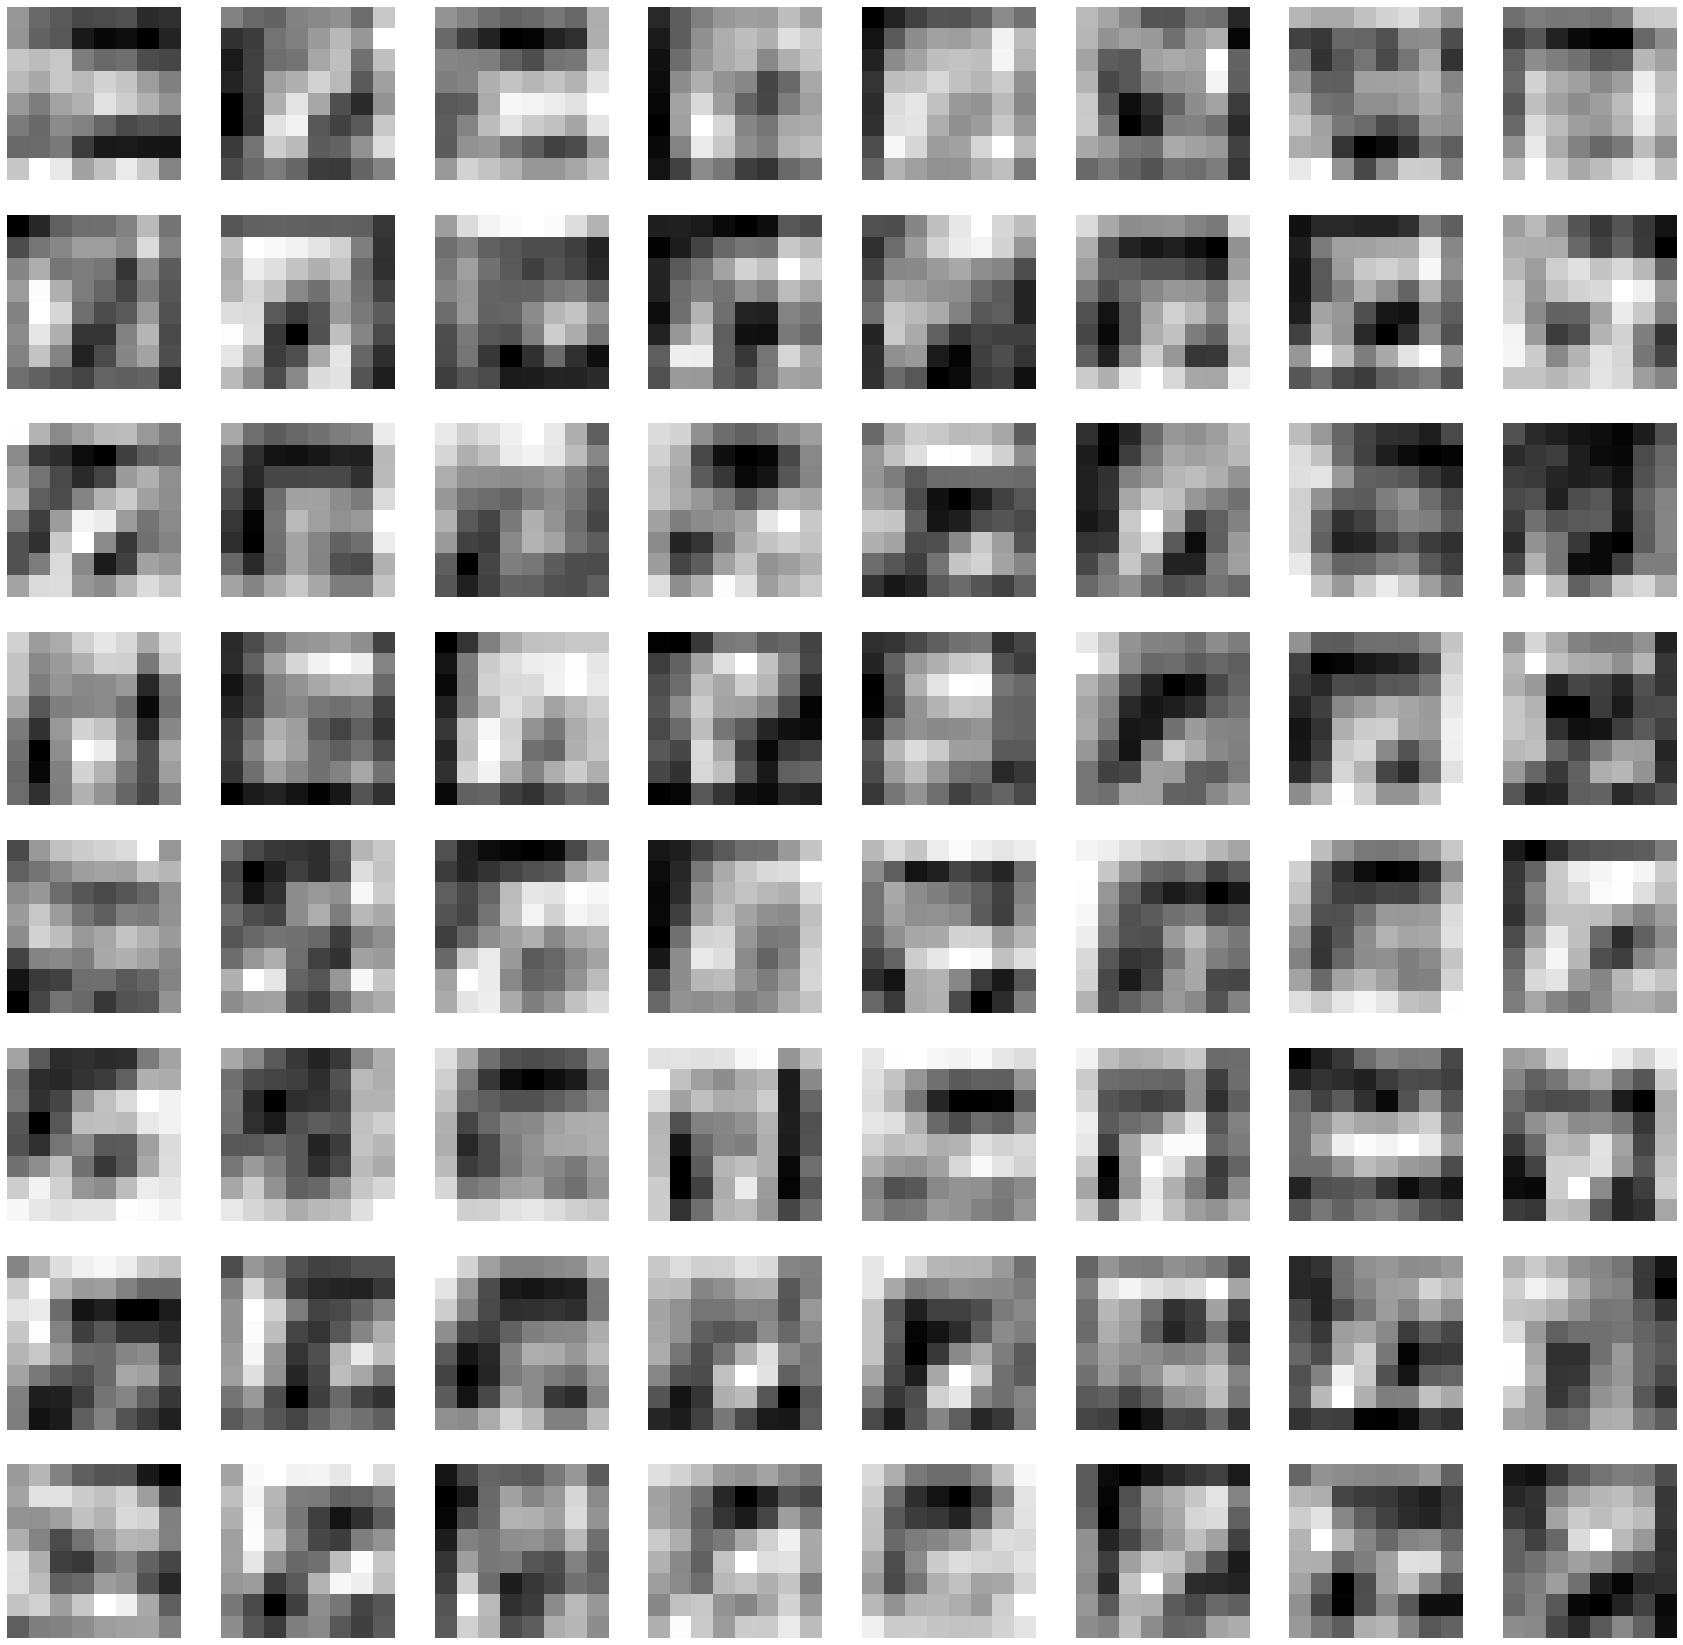

torch.Size([64, 4, 4])


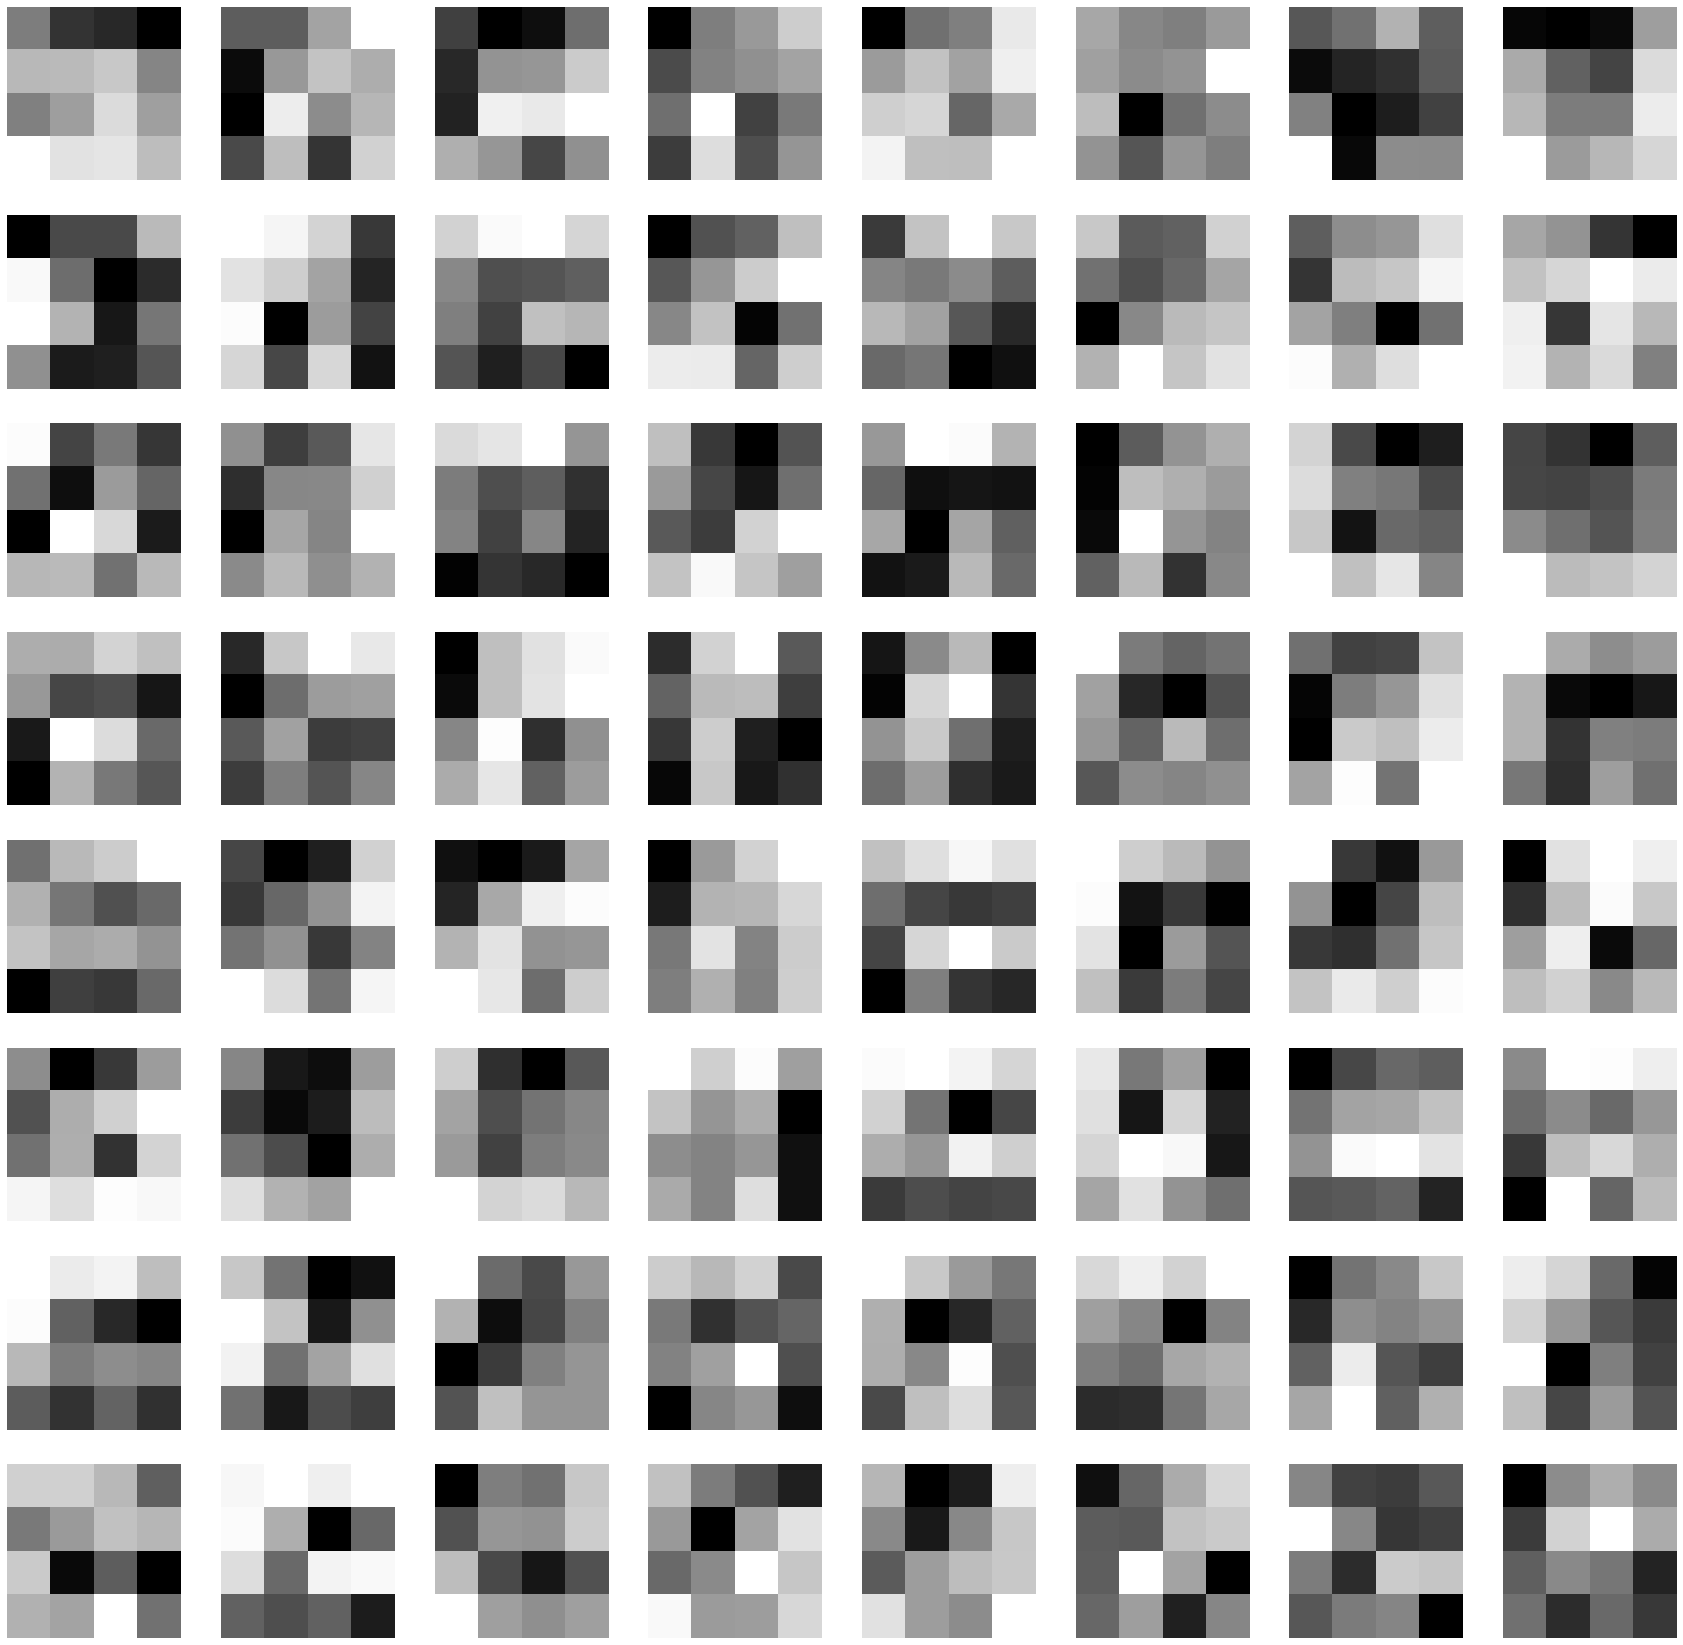

In [81]:
plot_feature_maps(conv_outputs)

## Single maxpool at end model visualization

In [27]:
import torch.nn as nn

class VGG(nn.Module):
    def vgg_conv_layers(self,number_convolutions, input_channels, output_channels):
        conv_layers = []
        for convolutions in range(number_convolutions):
            conv_layers.append(nn.Conv2d(input_channels,output_channels,kernel_size=3,padding=1))
            conv_layers.append(nn.BatchNorm2d(output_channels))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.Dropout(0))
            input_channels = output_channels
#         conv_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        return conv_layers
        
    def __init__(self, image, architecture):
        super(VGG, self).__init__()
        self.image = image
        self.blocks = []

        input_channels =self.image[0].shape[-1]
        for (number_convolutions, output_channels) in architecture:
            self.blocks.append(nn.Sequential(*self.vgg_conv_layers(number_convolutions, input_channels, output_channels)))
            input_channels = output_channels
#         flattened_size = output_channels*int(self.image[0].shape[0])*int(self.image[0].shape[0])
        self.blocks.append(nn.MaxPool2d(kernel_size=2, stride=2))

        flattened_size = output_channels*int(self.image[0].shape[0]/(2))*int(self.image[0].shape[0]/(2))

#         flattened_size = output_channels*int(self.image[0].shape[0]/(2**len(architecture)))*int(self.image[0].shape[0]/(2**len(architecture)))
        self.network = nn.Sequential(
            *self.blocks,
            nn.Flatten(),
            nn.Linear(flattened_size, int(flattened_size/4)),
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(int(flattened_size/4), int(flattened_size/8)), 
            nn.ReLU(), 
            nn.Dropout(0.4),
            nn.Linear(int(flattened_size/8), 10)
        )
        



    def forward(self, x, print_falg=False):
        if print_falg:
            for layer in self.network:
                x = layer(x)
                print("layer",layer.__class__.__name__,x.size())
            return x
        else:
            return self.network(x)
    

In [28]:
vgg_net = VGG(image_data, [(2,16),(2,32), (2,64)])

In [29]:
vgg_net.cuda()

VGG(
  (network): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0, inplace=False)
    )
    (2): Sequenti

In [31]:
import torch
vgg_net.load_state_dict(torch.load('model_vgg_net_arch_3/model_weights_dropout_0_1_maxpool'))

<All keys matched successfully>

In [36]:
predictions, true_labels = test(test_dataloader, vgg_net)

In [37]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)

In [38]:
# conv layer dropouts 0 FC layer dropouts 0.4
flat_true_labels = flat_true_labels.flatten()
np.sum(flat_predictions == flat_true_labels) / len(flat_true_labels)

0.6613333333333333

In [39]:
model_weights = []
convolution_layers = []
vgg_net_children = list(vgg_net.children())
for i in range(len(vgg_net_children)):
    if type(vgg_net_children[i]) == nn.Sequential:
        for j in range(len(vgg_net_children[i])):
            for child in vgg_net_children[i][j].children():
                if type(child) == nn.Conv2d:
                    model_weights.append(child.weight.detach().cpu().numpy())
                if type(child) == nn.Conv2d or type(child) == nn.MaxPool2d:
                    convolution_layers.append(child)

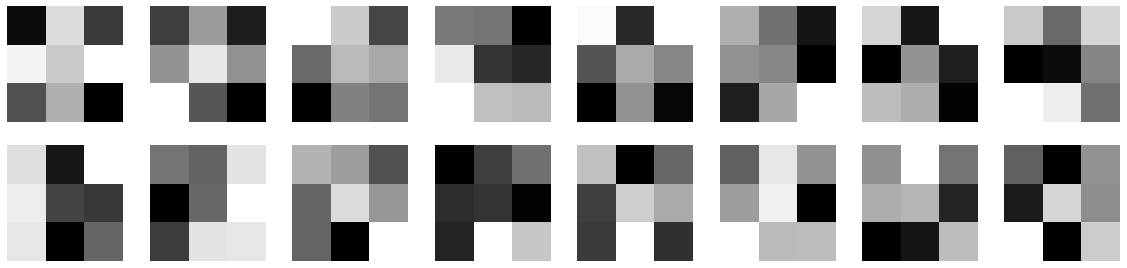

In [44]:
#after first block
visualize_filters(model_weights[1])

In [52]:
sample_image = list(test_dataloader)[0][0][12]


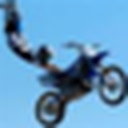

In [53]:
display_images((sample_image.detach().cpu().numpy().transpose((1,2,0))*255).astype('uint8'))

In [54]:
sample_image = list(test_dataloader)[0][0][12]
conv_outputs = [convolution_layers[0](sample_image.unsqueeze(0).cuda())]
for i in range(1, len(convolution_layers)):
    conv_outputs.append(convolution_layers[i](conv_outputs[-1]))

torch.Size([16, 32, 32])


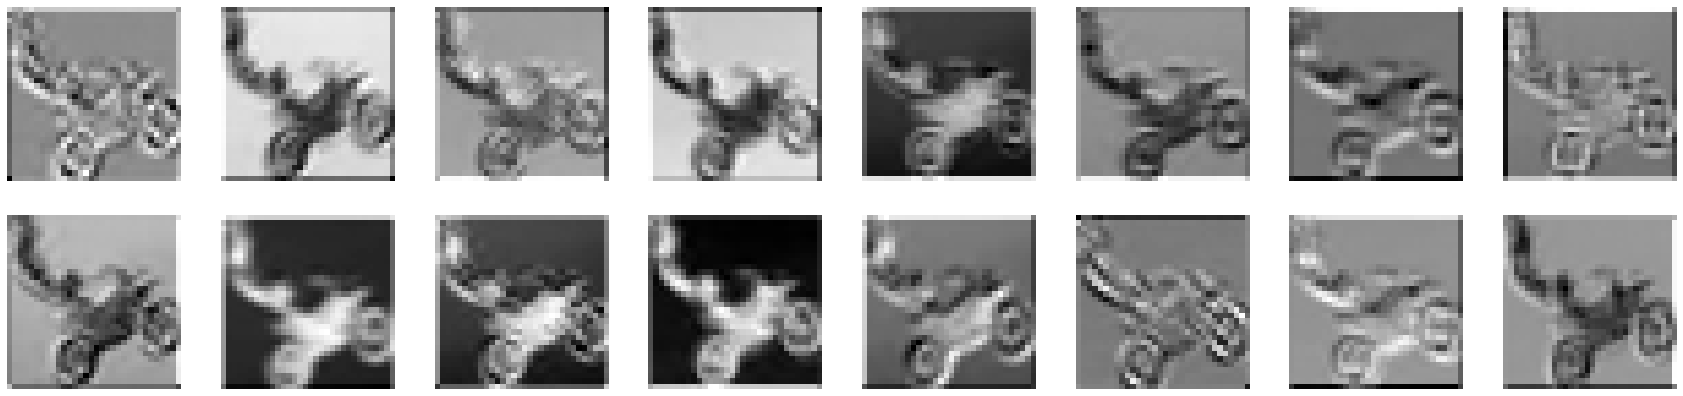

torch.Size([16, 32, 32])


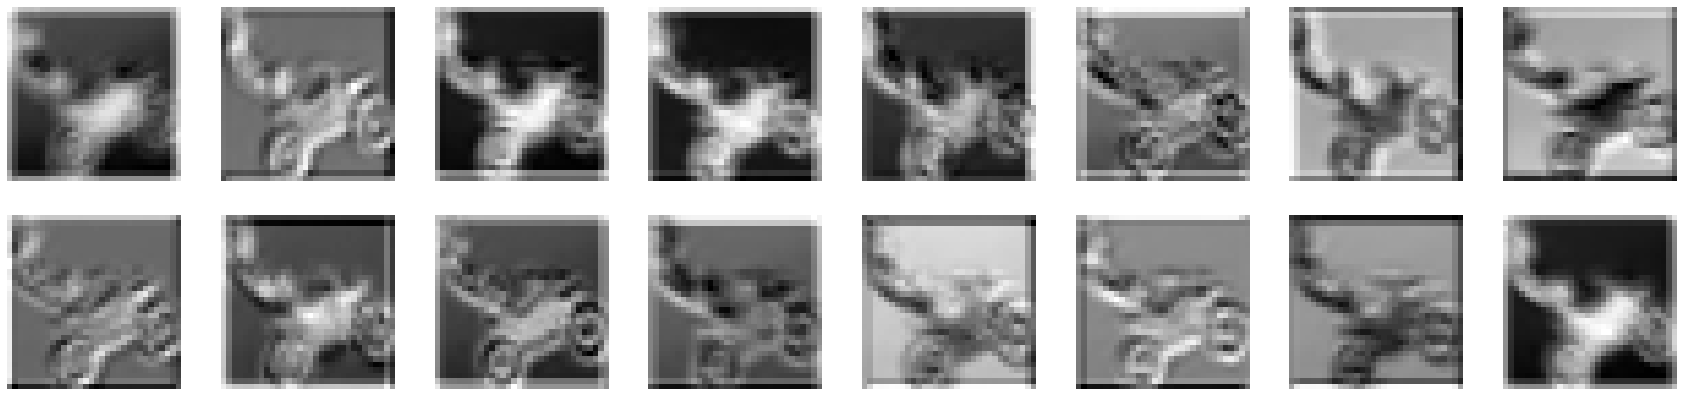

torch.Size([32, 32, 32])


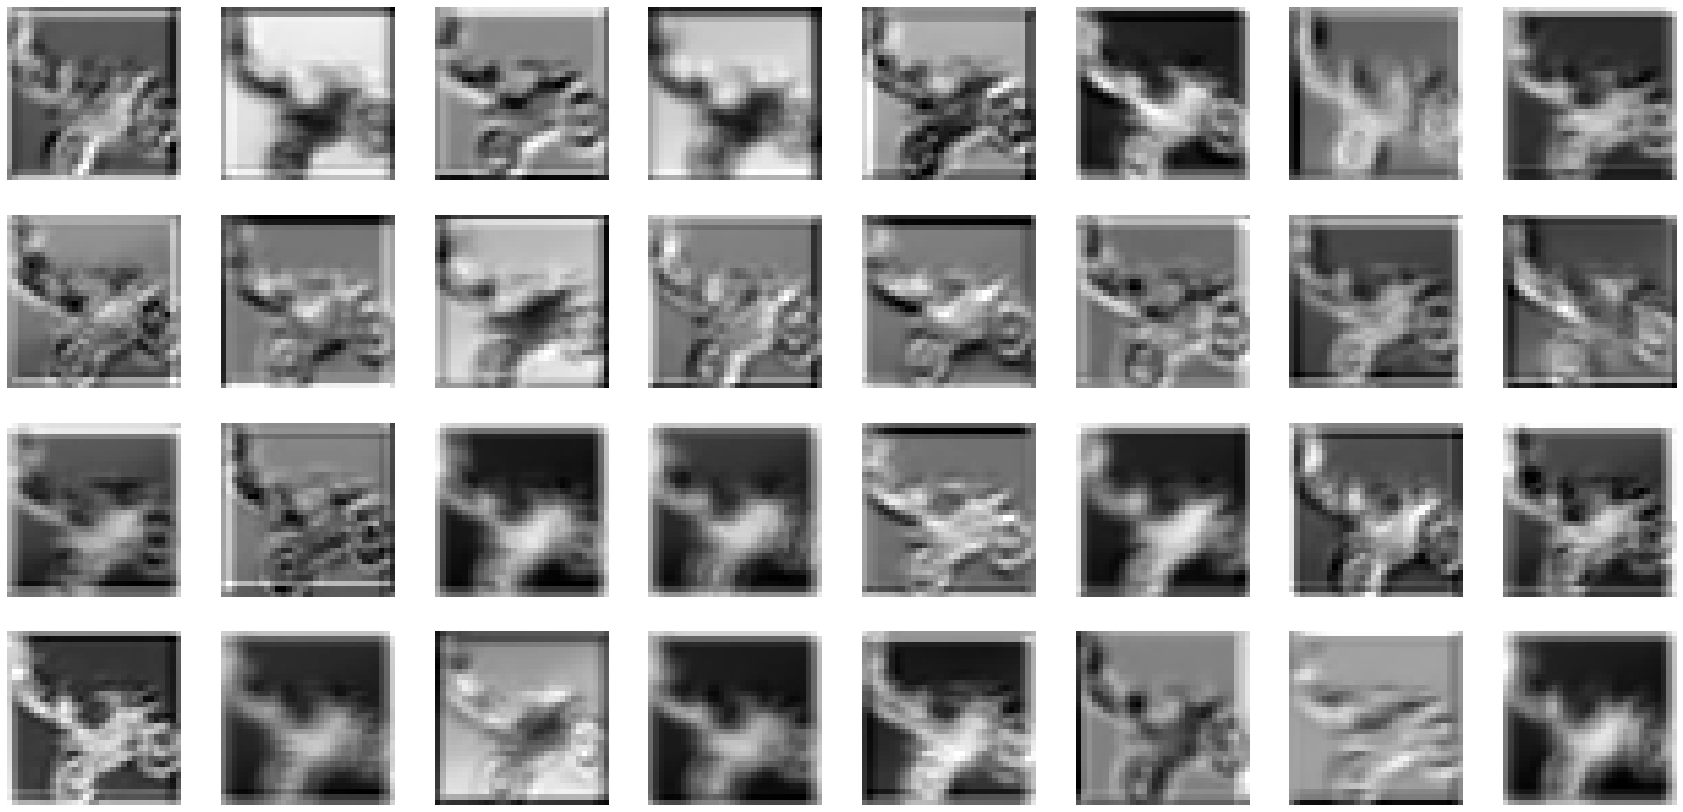

torch.Size([32, 32, 32])


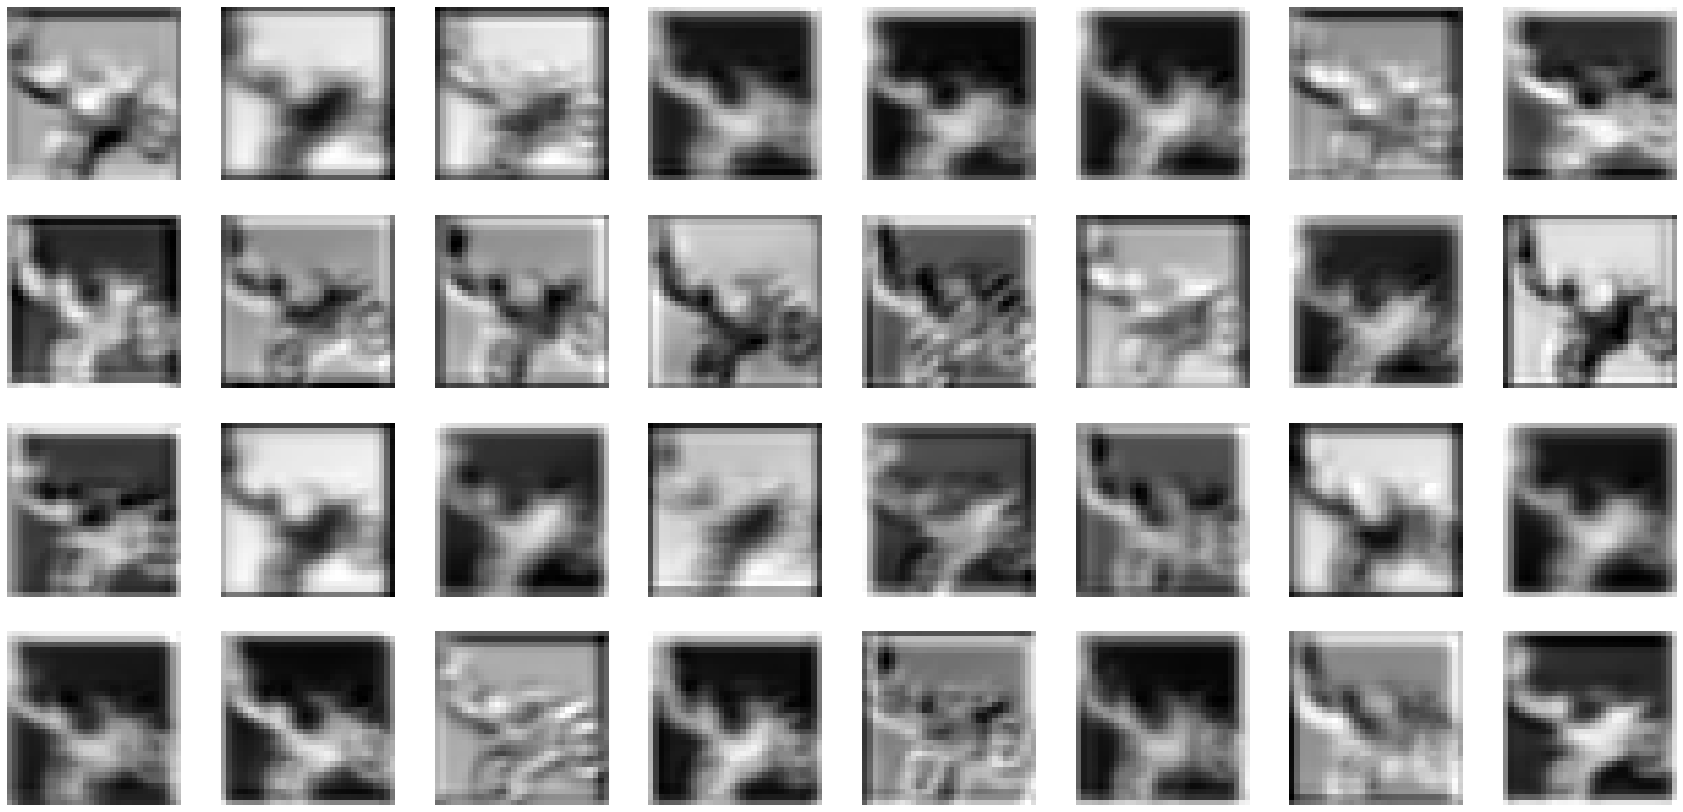

torch.Size([64, 32, 32])


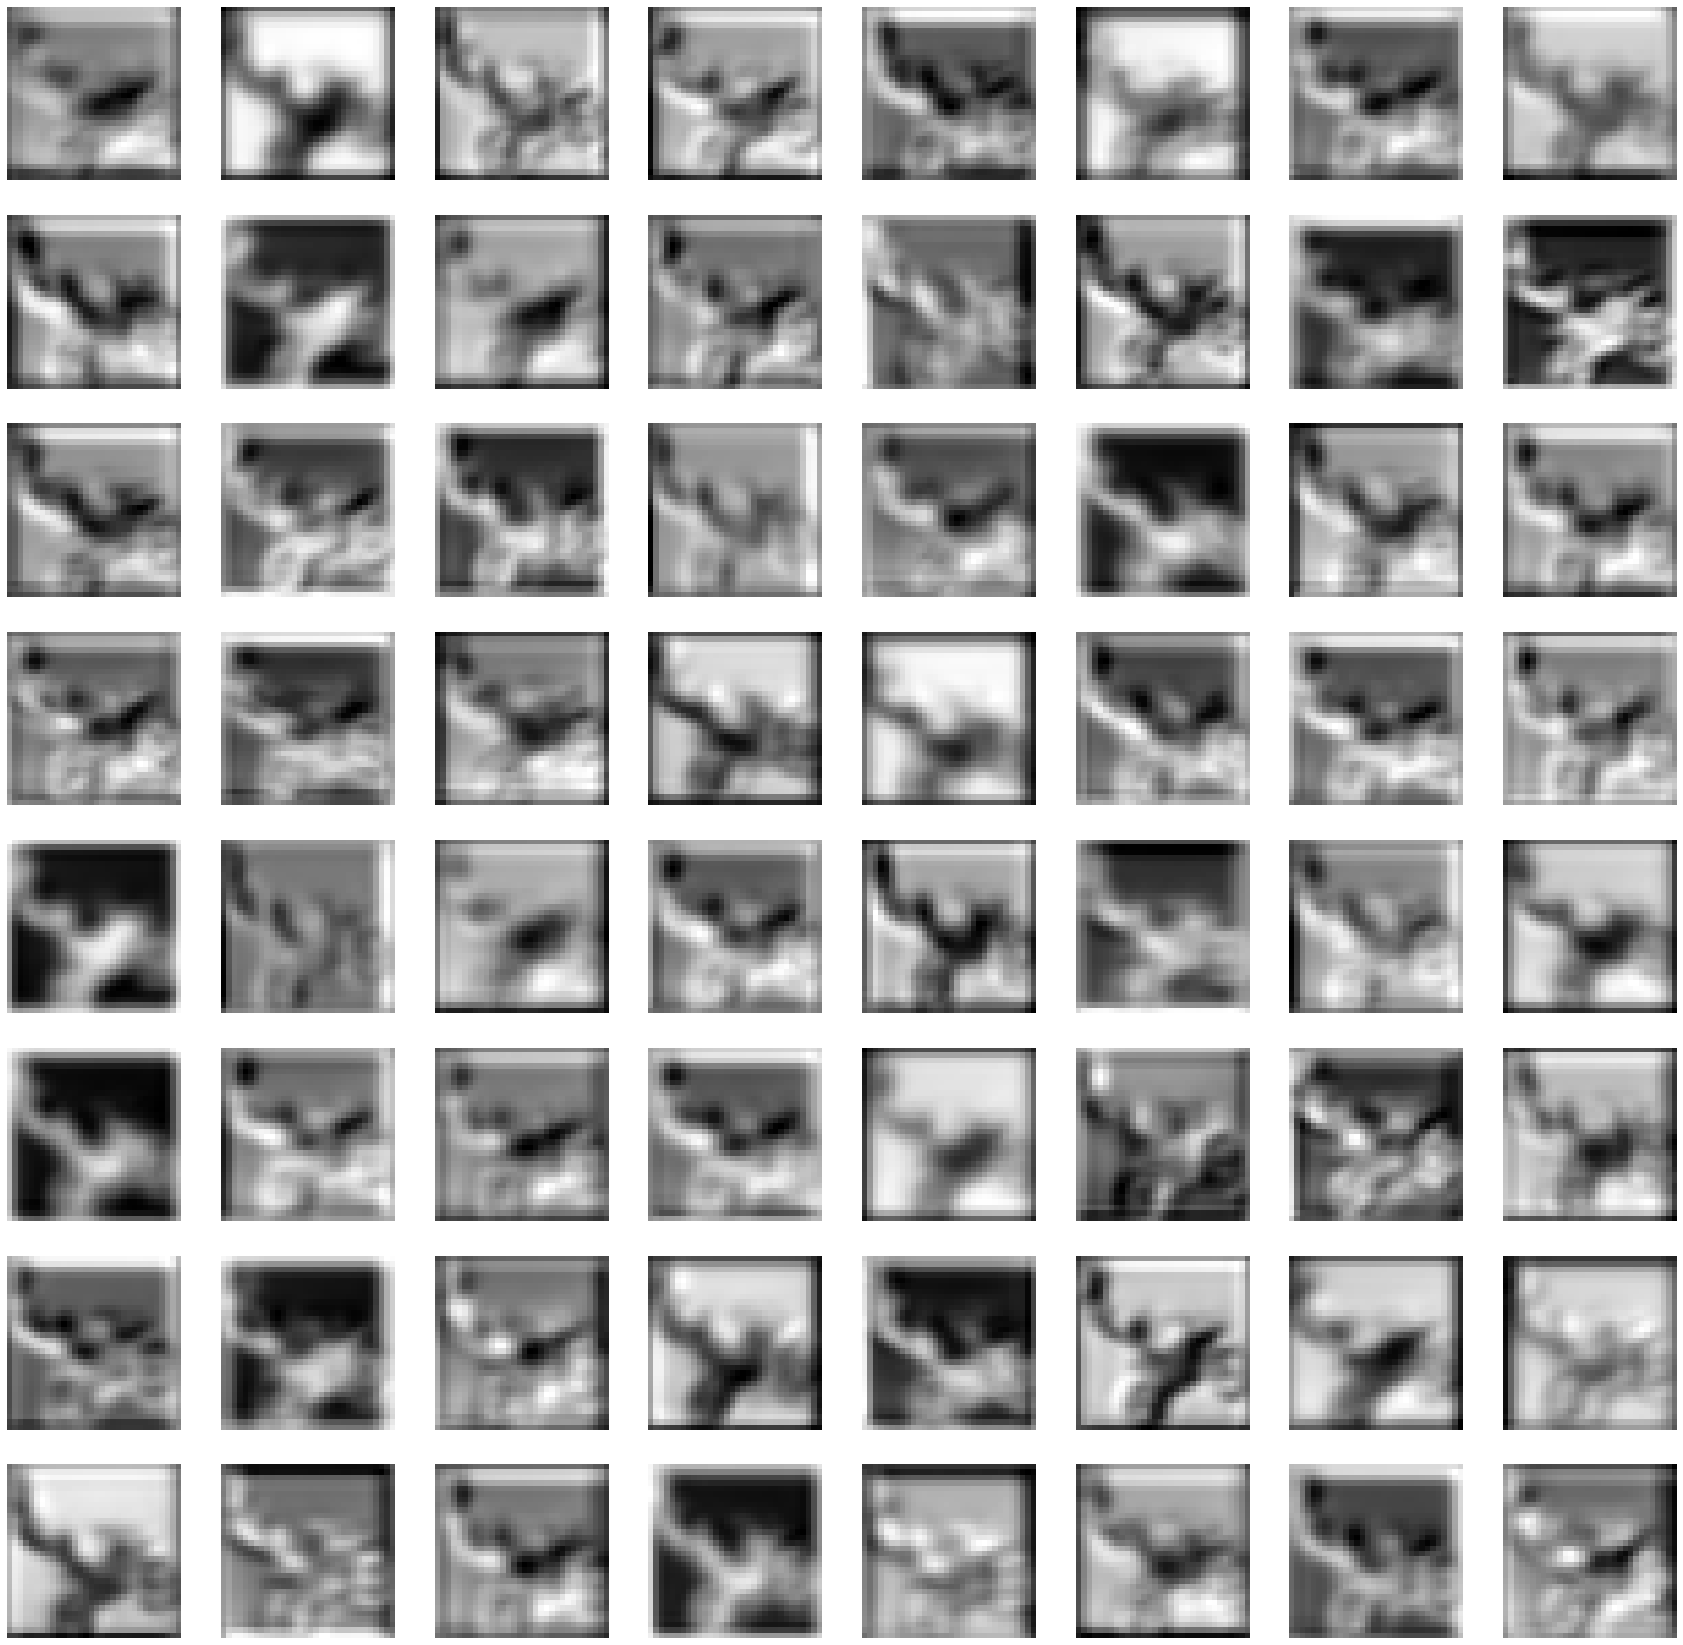

torch.Size([64, 32, 32])


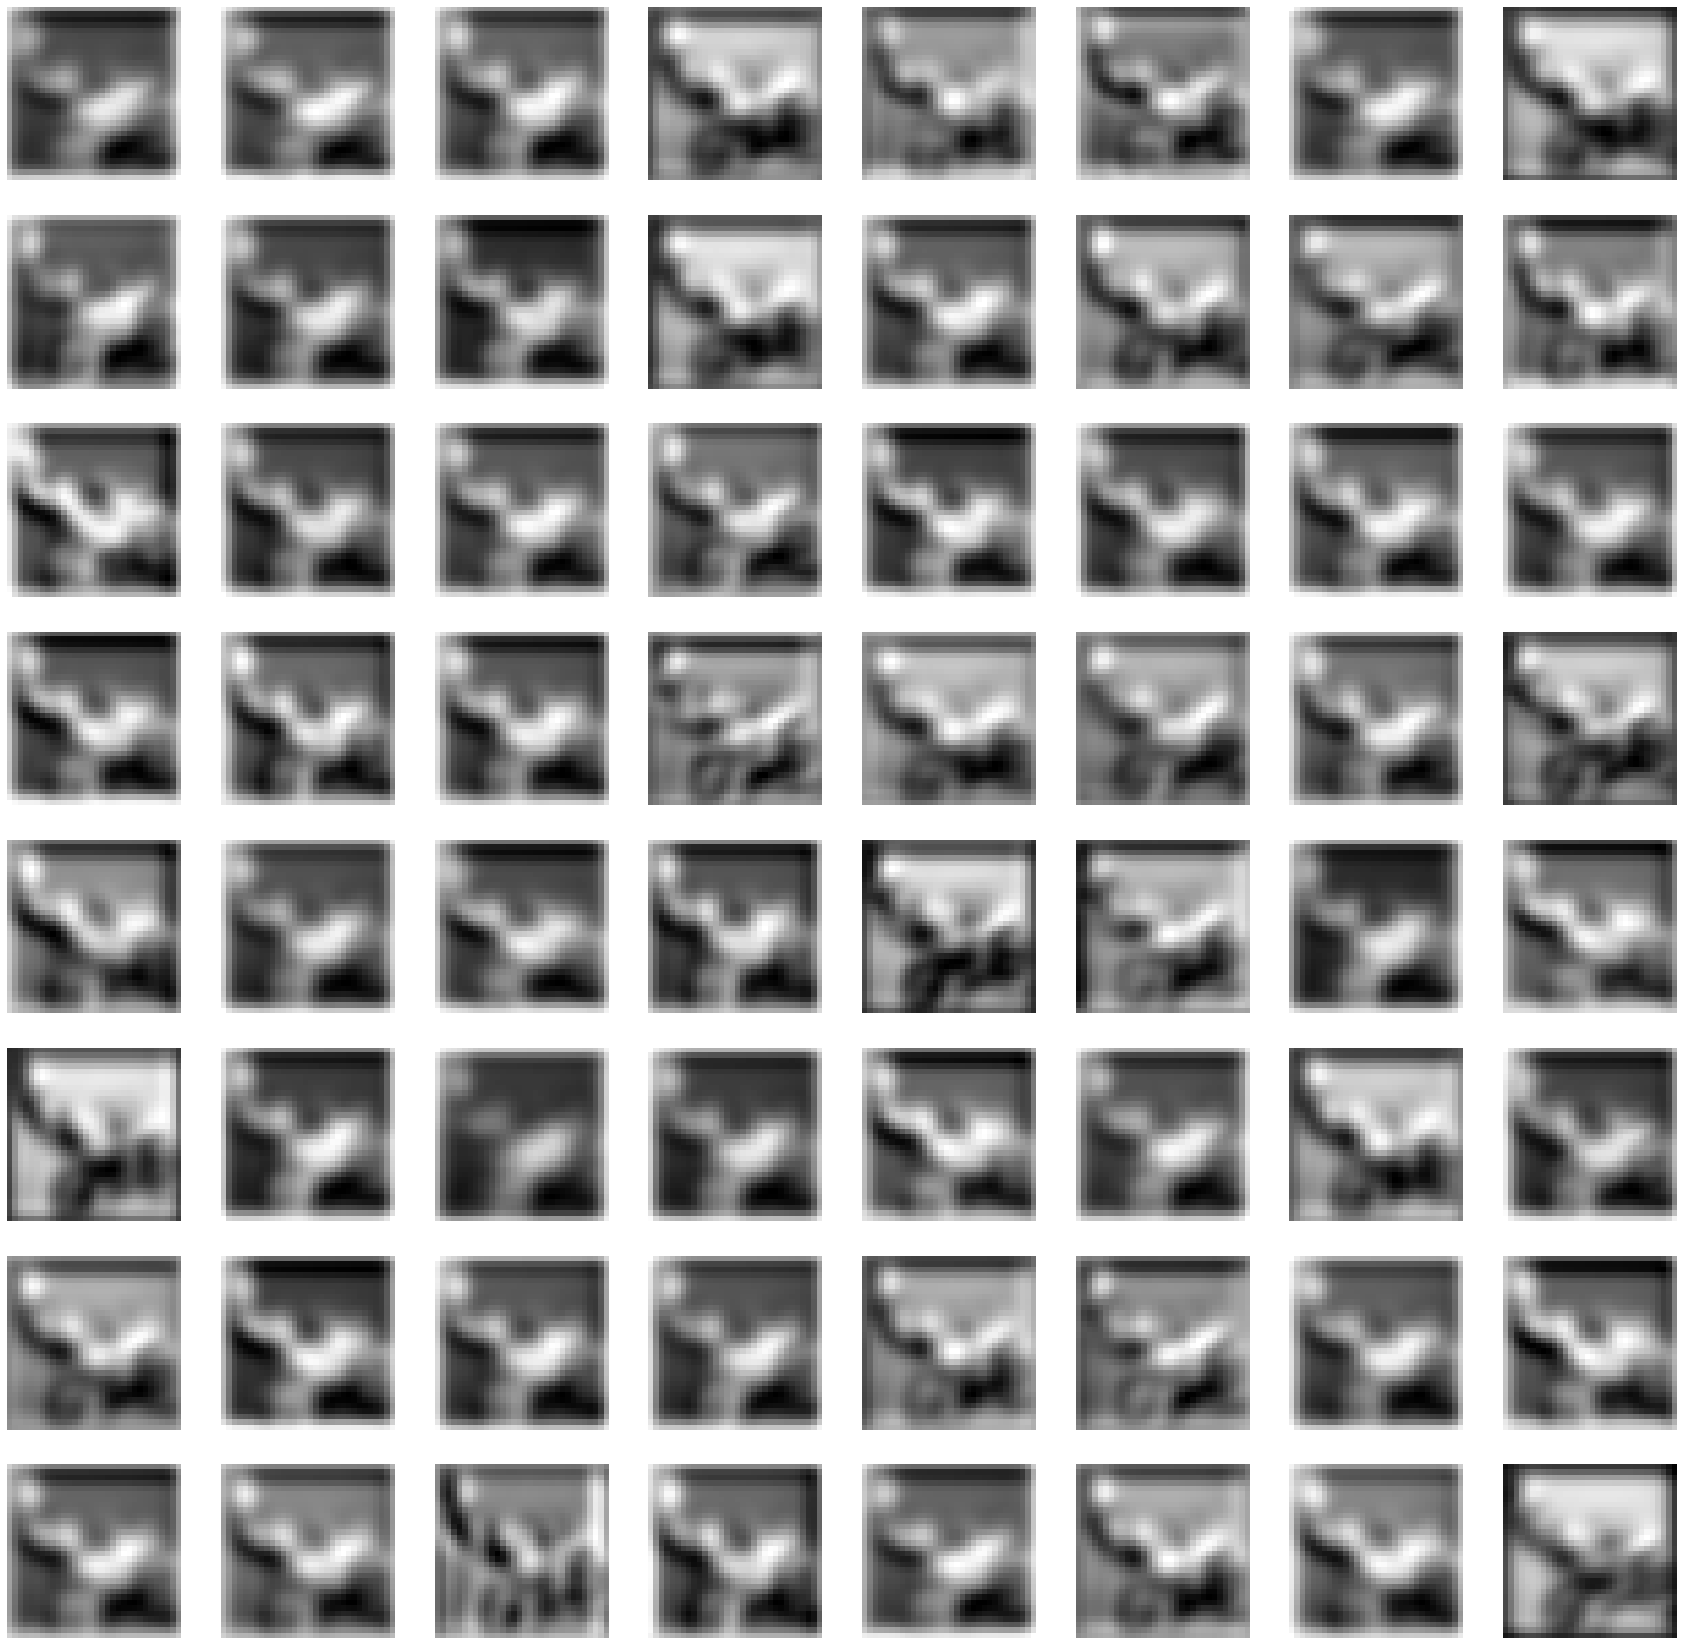

In [55]:
plot_feature_maps(conv_outputs)